## Import libraries

In [1]:
from stockfish import Stockfish
from stockfish import StockfishException
import pandas as pd
import numpy as np
import re
import os
import pickle
from concurrent.futures import ThreadPoolExecutor, as_completed
from timeit import default_timer as timer
import random
import string
import matplotlib.pyplot as plt
import seaborn as sns
import chess
import chess.svg
from IPython.display import SVG, display, HTML

## Import dataset

In [2]:
with open('valid_positions.txt') as f:
    pos = f.readlines()
pos1 = []
for i in range(len(pos)):
    pos1.append(re.sub('\n','', pos[i]))    
dataset = pos1

We are using a reduced version of the original dataset, with some invalid positions excluded

## Additional fucntions

In [3]:
#evaluation function
def evaluation(pos, elo, depth):
    stockfish = Stockfish('stockfish_15_x64_avx2.exe')
    stockfish.set_elo_rating(elo)        
    stockfish.set_depth(depth)
    stockfish.set_fen_position(pos)
    ev = stockfish.get_evaluation()
    pos = stockfish.get_top_moves(1)
    return ev, pos

def evaluationdouble(pos1, pos2, elo, depth):
    stockfish = Stockfish('C:/Users/axel/Git/MT_ChessEngines/stockfish_15_x64_avx2.exe')
    stockfish.set_elo_rating(elo)
    stockfish.set_depth(depth)
    stockfish.set_fen_position(pos1)
    ev1 = stockfish.get_evaluation()
    stockfish.set_fen_position(pos2)
    ev2 = stockfish.get_evaluation()
    return ev1, ev2

def show_pos(fen_list, size, space=10):
    boards = [chess.Board(fen) for fen in fen_list]
    svg_boards = [chess.svg.board(board=board, size=size) for board in boards]
    html_code = "<div style='display: inline-block; margin-right: {}px;'>{}</div>".format(space, "</div><div style='display: inline-block; margin-right: {}px;'>".format(space).join(svg_boards))
    display(HTML(html_code))


In [4]:
#delta
def dif1(val1, val2):
    if abs(val1) + abs(val2) == 0:
        return 0
    else:
        return abs(val1 - val2) / (abs(val1) + abs(val2))

#epsilon
def dif2(val1, val2):
    return float(abs(val1 - val2))

In [5]:
def checkcheckW(pos):
    def make_matrix(board):  # type(board) == chess.Board()
        pgn = board
        foo = []  # Final board
        pieces = pgn.split(" ", 1)[0]
        rows = pieces.split("/")
        for row in rows:
            foo2 = []  # This is the row I make
            for thing in row:
                if thing.isdigit():
                    for i in range(0, int(thing)):
                        foo2.append('.')
                else:
                    foo2.append(thing)
            foo.append(foo2)
        return foo

    whites = ['Q', 'K', 'R', 'B', 'N', 'P']
    blacks = ['q', 'k', 'r', 'b', 'n', 'p']
    a = make_matrix(pos)
    check = False
    pos = []
    for i in range(8):
        for j in range(8):
            if a[i][j] == 'K':
                pos.append(i)
                pos.append(j)
    for i in list(reversed(range(pos[1]))):
        if a[pos[0]][i] in whites or a[pos[0]][i] in list(blacks[j] for j in [1, 3, 4, 5]):
            break
        elif a[pos[0]][i] == 'q' or a[pos[0]][i] == 'r':
            check = True
            break
    for i in list(range(pos[1] + 1, 8)):
        if a[pos[0]][i] in whites or a[pos[0]][i] in list(blacks[j] for j in [1, 3, 4, 5]):
            break
        elif a[pos[0]][i] == 'q' or a[pos[0]][i] == 'r':
            check = True
            break
    for i in list(reversed(range(pos[0]))):
        if a[i][pos[1]] in whites or a[i][pos[1]] in list(blacks[j] for j in [1, 3, 4, 5]):
            break
        elif a[i][pos[1]] == 'q' or a[i][pos[1]] == 'r':
            check = True
            break
    for i in list(range(pos[0] + 1, 8)):
        if a[i][pos[1]] in whites or a[i][pos[1]] in list(blacks[j] for j in [1, 3, 4, 5]):
            break
        elif a[i][pos[1]] == 'q' or a[i][pos[1]] == 'r':
            check = True
            break
    r = 8 - np.maximum(abs(pos[0]), abs(pos[1]))
    r1 = np.minimum(abs(pos[0]), abs(pos[1]))
    r2 = np.minimum(r, r1)
    for i in list(range(1, r)):
        if a[pos[0] + i][pos[1] + i] in whites or a[pos[0] + i][pos[1] + i] in list(blacks[j] for j in [1, 2, 4, 5]):
            break
        elif a[pos[0] + i][pos[1] + i] == 'b' or a[pos[0] + i][pos[1] + i] == 'q':
            check = True
            break
    for i in list(range(1, r2)):
        if a[pos[0] - i][pos[1] + i] in whites or a[pos[0] - i][pos[1] + i] in list(blacks[j] for j in [1, 2, 4, 5]):
            break
        elif a[pos[0] - i][pos[1] + i] == 'b' or a[pos[0] - i][pos[1] + i] == 'q':
            check = True
            break
    for i in list(range(1, r2)):
        if a[pos[0] - i][pos[1] - i] in whites or a[pos[0] - i][pos[1] - i] in list(blacks[j] for j in [1, 2, 4, 5]):
            break
        elif a[pos[0] - i][pos[1] - i] == 'b' or a[pos[0] - i][pos[1] - i] == 'q':
            check = True
            break
    for i in list(range(1, r)):
        if a[pos[0] + i][pos[1] - i] in whites or a[pos[0] + i][pos[1] - i] in list(blacks[j] for j in [1, 2, 4, 5]):
            break
        elif a[pos[0] + i][pos[1] - i] == 'b' or a[pos[0] + i][pos[1] - i] == 'q':
            check = True
            break
    if pos[0] + 2 < 8 and pos[1] - 1 > 0 and a[pos[0] + 2][pos[1] - 1] == 'n':
        check = True
    if pos[0] + 2 < 8 and pos[1] + 1 < 8 and a[pos[0] + 2][pos[1] + 1] == 'n':
        check = True
    if pos[0] - 2 > 0 and pos[1] - 1 > 0 and a[pos[0] - 2][pos[1] - 1] == 'n':
        check = True
    if pos[0] - 2 > 0 and pos[1] + 1 < 8 and a[pos[0] - 2][pos[1] + 1] == 'n':
        check = True
    if pos[0] + 1 < 8 and pos[1] - 2 > 0 and a[pos[0] + 1][pos[1] - 2] == 'n':
        check = True
    if pos[0] + 1 < 8 and pos[1] + 2 < 8 and a[pos[0] + 1][pos[1] + 2] == 'n':
        check = True
    if pos[0] - 1 > 0 and pos[1] - 2 > 0 and a[pos[0] - 1][pos[1] - 2] == 'n':
        check = True
    if pos[0] - 1 > 0 and pos[1] + 2 < 8 and a[pos[0] - 1][pos[1] + 2] == 'n':
        check = True
    if pos[0] - 1 > 0 and pos[1] - 1 > 0 and a[pos[0] - 1][pos[1] - 1] == 'p':
        check = True
    if pos[0] - 1 > 0 and pos[1] + 1 < 8 and a[pos[0] - 1][pos[1] + 1] == 'p':
        check = True
    return check


def checkcheckB(pos):
    def make_matrix(board):  # type(board) == chess.Board()
        pgn = board
        foo = []  # Final board
        pieces = pgn.split(" ", 1)[0]
        rows = pieces.split("/")
        for row in rows:
            foo2 = []  # This is the row I make
            for thing in row:
                if thing.isdigit():
                    for i in range(0, int(thing)):
                        foo2.append('.')
                else:
                    foo2.append(thing)
            foo.append(foo2)
        return foo

    whites = ['Q', 'K', 'R', 'B', 'N', 'P']
    blacks = ['q', 'k', 'r', 'b', 'n', 'p']
    a = make_matrix(pos)
    check = False
    pos = []
    for i in range(8):
        for j in range(8):
            if a[i][j] == 'k':
                pos.append(i)
                pos.append(j)
    for i in list(reversed(range(pos[1]))):
        if a[pos[0]][i] in blacks or a[pos[0]][i] in list(whites[j] for j in [1, 3, 4, 5]):
            break
        elif a[pos[0]][i] == 'Q' or a[pos[0]][i] == 'R':
            check = True
            break
    for i in list(range(pos[1] + 1, 8)):
        if a[pos[0]][i] in blacks or a[pos[0]][i] in list(whites[j] for j in [1, 3, 4, 5]):
            break
        elif a[pos[0]][i] == 'Q' or a[pos[0]][i] == 'R':
            check = True
            break
    for i in list(reversed(range(pos[0]))):
        if a[i][pos[1]] in blacks or a[i][pos[1]] in list(whites[j] for j in [1, 3, 4, 5]):
            break
        elif a[i][pos[1]] == 'Q' or a[i][pos[1]] == 'R':
            check = True
            break
    for i in list(range(pos[0] + 1, 8)):
        if a[i][pos[1]] in blacks or a[i][pos[1]] in list(whites[j] for j in [1, 3, 4, 5]):
            break
        elif a[i][pos[1]] == 'Q' or a[i][pos[1]] == 'R':
            check = True
            break
    r = 8 - np.maximum(abs(pos[0]), abs(pos[1]))
    r1 = np.minimum(abs(pos[0]), abs(pos[1]))
    r2 = np.minimum(r, r1)
    for i in list(range(1, r)):
        if a[pos[0] + i][pos[1] + i] in blacks or a[pos[0] + i][pos[1] + i] in list(whites[j] for j in [1, 2, 4, 5]):
            break
        elif a[pos[0] + i][pos[1] + i] == 'B' or a[pos[0] + i][pos[1] + i] == 'Q':
            check = True
            break
    for i in list(range(1, r2)):
        if a[pos[0] - i][pos[1] + i] in blacks or a[pos[0] - i][pos[1] + i] in list(whites[j] for j in [1, 2, 4, 5]):
            break
        elif a[pos[0] - i][pos[1] + i] == 'B' or a[pos[0] - i][pos[1] + i] == 'Q':
            check = True
            break
    for i in list(range(1, r2)):
        if a[pos[0] - i][pos[1] - i] in blacks or a[pos[0] - i][pos[1] - i] in list(whites[j] for j in [1, 2, 4, 5]):
            break
        elif a[pos[0] - i][pos[1] - i] == 'B' or a[pos[0] - i][pos[1] - i] == 'Q':
            check = True
            break
    for i in list(range(1, r)):
        if a[pos[0] + i][pos[1] - i] in blacks or a[pos[0] + i][pos[1] - i] in list(whites[j] for j in [1, 2, 4, 5]):
            break
        elif a[pos[0] + i][pos[1] - i] == 'B' or a[pos[0] + i][pos[1] - i] == 'Q':
            check = True
            break
    if pos[0] + 2 < 8 and pos[1] - 1 > 0 and a[pos[0] + 2][pos[1] - 1] == 'N':
        check = True
    if pos[0] + 2 < 8 and pos[1] + 1 < 8 and a[pos[0] + 2][pos[1] + 1] == 'N':
        check = True
    if pos[0] - 2 > 0 and pos[1] - 1 > 0 and a[pos[0] - 2][pos[1] - 1] == 'N':
        check = True
    if pos[0] - 2 > 0 and pos[1] + 1 < 8 and a[pos[0] - 2][pos[1] + 1] == 'N':
        check = True
    if pos[0] + 1 < 8 and pos[1] - 2 > 0 and a[pos[0] + 1][pos[1] - 2] == 'N':
        check = True
    if pos[0] + 1 < 8 and pos[1] + 2 < 8 and a[pos[0] + 1][pos[1] + 2] == 'N':
        check = True
    if pos[0] - 1 > 0 and pos[1] - 2 > 0 and a[pos[0] - 1][pos[1] - 2] == 'N':
        check = True
    if pos[0] - 1 > 0 and pos[1] + 2 < 8 and a[pos[0] - 1][pos[1] + 2] == 'N':
        check = True
    if pos[0] - 1 > 0 and pos[1] - 1 > 0 and a[pos[0] - 1][pos[1] - 1] == 'P':
        check = True
    if pos[0] - 1 > 0 and pos[1] + 1 < 8 and a[pos[0] - 1][pos[1] + 1] == 'P':
        check = True
    return check


def bothcheck(pos):
    both = False
    if checkcheckB(pos) == True and checkcheckW(pos) == True:
        both = True
    return both

## Functions to alterate positions

In [6]:
def sim_axis(pos):
    pos_transformed = []
    col = pos[-1:]
    aux1 = pos[:-2]
    aux2 = aux1.split("/")
    aux3 = []
    for j in range(8):
        aux3.append(aux2[j][::-1])
    aux4 = '/'.join(aux3)
    pos_transformed.append(aux4)
    if col == 'w':
        pos_transformed = pos_transformed[0] + ' w'
    if col == 'b':
        pos_transformed = pos_transformed[0] + ' b'
    return pos_transformed


def sim_diag(pos):
    def Convert(string):
        list1 = []
        list1[:0] = string
        return list1

    pos_transformed = []
    colour = pos[-1:]
    aux = pos.replace('8', '11111111').replace('7', '1111111').replace('6', '111111').replace('5', '11111').replace('4',
                                                                                                                    '1111').replace(
        '3', '111').replace('2', '11')
    aux2 = aux.split('/')
    for i in range(8):
        aux2[i] = Convert(aux2[i])
        aux3 = [] * 8

    for j in reversed(range(8)):
        aux4 = []
        for i in reversed(range(8)):
            aux4.append(aux2[i][j])
        aux3.append(aux4)
    for i in reversed(range(8)):
        aux3[i] = "".join(aux3[i])
    pos_transformed = "/".join(aux3)
    if colour == 'b':
        pos_transformed = pos_transformed + ' b'
    else:
        pos_transformed = pos_transformed + ' w'
    pos_transformed = pos_transformed.replace('11111111', '8').replace('1111111', '7').replace('111111', '6').replace(
        '11111', '5').replace('1111', '4').replace('111', '3').replace('11', '2')

    return pos_transformed


def sim_mirror(pos):
    pos_transformed = []
    colour = pos[-1:]
    aux1 = pos[:-2]
    aux2 = aux1.swapcase()
    aux3 = aux2.split("/")
    aux4 = []
    for j in reversed(aux3):
        aux4.append(j)
        aux5 = '/'.join(aux4)
    pos_transformed.append(aux5)
    if colour == 'b':
        pos_transformed = pos_transformed[0] + ' w'
    else:
        pos_transformed = pos_transformed[0] + ' b'
    return pos_transformed


def replace(pos):
    if pos.count('B') > 0 & pos.count('R') > 0:
        n = random.random()
        if n > 0.5:
            aux = pos.replace('R', 'Q', 1)
        else:
            aux = pos.replace('B', 'Q', 1)
    elif pos.count('B') > 0 & pos.count('R') == 0:
        aux = pos.replace('B', 'Q', 1)
    elif pos.count('R') > 0 & pos.count('B') == 0:
        aux = pos.replace('R', 'Q', 1)
    else:
        aux = pos
    return aux

## MRs

In [7]:
#for sim_axis and sim_diag
def MR_equi(o1, o2, delta, epsilon):
    final = False
    if o1.get('type') != o2.get('type'):
        final = False
    elif o1.get('type') == o2.get('type') == 'mate' and o1.get('value') != o2.get('value'):
        final = False
    elif o1.get('type') == o2.get('type') == 'cp' and dif1(o1.get('value'), o2.get('value')) > delta and dif2(
            o1.get('value'), o2.get('value')) >= epsilon:
        final = False
    else:
        final = True
    return final

#for sim_mirror
def MR_mirror(o1, o2, delta, epsilon):
    final = False
    if o1.get('type') != o2.get('type'):
        final = False
    elif o1.get('type') == o2.get('type') == 'mate' and o1.get('value') != (-1 * o2.get('value')):
        final = False
    elif o1.get('type') == o2.get('type') == 'cp' and dif1(o1.get('value'), (-1 * o2.get('value'))) > delta and dif2(
            o1.get('value'), (-1 * o2.get('value'))) >= epsilon:
        final = False
    else:
        final = True
    return final

#for replace
def MR_better_original(o1,o2,delta,epsilon):
    final = bool()
    if o1.get('type') != o2.get('type') and o2.get('type') != 'mate':
        final = False
    elif o1.get('type') == o2.get('type') == 'mate' and o1.get('value') < o2.get('value') and o1.get('value') > 0:
        final = False
    elif o1.get('type') == o2.get('type') == 'mate' and o1.get('value') > o2.get('value') and o1.get('value') < 0:
        final = False
    elif o1.get('type') == o2.get('type') == 'cp' and o1.get('value') > o2.get('value') and dif1(o1.get('value'),o2.get('value')) > delta and dif2(o1.get('value'),o2.get('value')) >= epsilon:
        final = False
    else:
        final = True
    return final

#when using the evaluation after the best move
def MR_first(o1, o2, delta, epsilon):
    final = False
    if o1[0].get('Mate') != o2[0].get('Mate'):
        final = False
    elif o1[0].get('Mate') == o2[0].get('Mate') == None and dif1(o1[0].get('Centipawn'),
                                                                 o2[0].get('Centipawn')) > delta and dif2(
            o1[0].get('Centipawn'), o2[0].get('Centipawn')) >= epsilon:
        final = False
    else:
        final = True
    return final

### Problem with the original MR_better : example

In [8]:
pos = '1B1n1r2/8/8/1n5b/3r4/8/5k2/2K5'
pos2 = replace(pos)
ev1 = evaluation(pos,5000,10)[0]
ev2 = evaluation (pos2, 5000, 10)[0]

print(ev1, '\n', ev2)

{'type': 'mate', 'value': -10} 
 {'type': 'cp', 'value': -824}


Before replace --> mate in 10 for Black
After replace --> advantage of 824 centipawns for Black

The evaluation got better for White, which should meet the MR requirements but:

In [9]:
print(MR_better_original(ev1,ev2,1,100))

False


It seems that some conditions are incorrect in the original MR_better function, so we modified it as follows:

In [10]:
def MR_better(o1, o2, delta, epsilon):
    final = False
    # knowing that we're upgrading white pieces (always)
    # if we switch from diff in centipawns to mate for Black --> False
    if o1.get('type') == 'cp' and o2.get('type') == 'mate' and o2.get('value') < 0:
        final = False
    # if we switch from mate to diff in centipawns for White --> False
    elif o1.get('type') == 'mate' and o2.get('type') == 'cp' and o1.get('value') > 0:
        final = False
    # ex : from #7 to #9 --> False
    elif o1.get('type') == o2.get('type') == 'mate' and o2.get('value') > o1.get('value') > 0:
        final = False
    # ex : from #-9 to #-7 --> False
    elif o1.get('type') == o2.get('type') == 'mate' and 0 > o2.get('value') > o1.get('value'):
        final = False
    # ex : from #5 to #-5 --> False
    elif o1.get('type') == o2.get('type') == 'mate' and o1.get('value') > 0 > o2.get('value'):
        final = False
    # if centipawns diff for both evaluations, will depend on thresholds
    elif o1.get('type') == o2.get('type') == 'cp' and o1.get('value') > o2.get('value') and dif1(o1.get('value'),
                                                                                                 o2.get('value')) > delta and dif2(
            o1.get('value'), o2.get('value')) >= epsilon:
        final = False
    else:
        final = True
    return final

## Main functions

### Function for mass evaluations

In [11]:

def main(dataset, elo, depth, type):
    global threadsfinis
    global threadstotaux
    pos1 = []
    pos2 = []
    results1 = []
    results2 = []
    start = timer()
    index = []
    if type == 0:
        for i in range(len(dataset)):
            if bothcheck(dataset[i]) == False and bothcheck(sim_mirror(dataset[i])) == False:
                if i%5==0:
                    print(i)
                try:
                    ev1 = evaluation(dataset[i], elo, depth)[0]
                    ev2 = evaluation(sim_mirror(dataset[i]), elo, depth)[0]
                    pos1.append(dataset[i])  ## adding original position to dataframe
                    pos2.append(sim_mirror(dataset[i]))  ## adding transformed position to dataframe
                    results1.append(ev1)  ## adding evaluation of original position to dataframe
                    results2.append(ev2)  ## adding evaluation of transformed position to dataframe
                    index.append(i)  ## adding index to dataframe
                except StockfishException:
                    pass
    elif type == 1:
        for i in range(len(dataset)):
            if bothcheck(dataset[i]) == False and bothcheck(sim_axis(dataset[i])) == False:
                if i%5==0:
                    print(i)
                try:
                    ev1 = evaluation(dataset[i], elo, depth)[0]
                    ev2 = evaluation(sim_axis(dataset[i]), elo, depth)[0]
                    pos1.append(dataset[i])  ## adding original position to dataframe
                    pos2.append(sim_axis(dataset[i]))  ## adding transformed position to dataframe
                    results1.append(ev1)  ## adding evaluation of original position to dataframe
                    results2.append(ev2)  ## adding evaluation of transformed position to dataframe
                    index.append(i)  ## adding index to dataframe
                except StockfishException:
                    pass
    elif type == 2:
        for i in range(len(dataset)):
            #ignoring positions with pawns
            if bothcheck(dataset[i]) == False and bothcheck(sim_diag(dataset[i])) == False and 'p' not in dataset[
                i] and 'P' not in dataset[i]:
                if i%5==0:
                    print(i)
                try:
                    ev1 = evaluation(dataset[i], elo, depth)[0]
                    ev2 = evaluation(sim_diag(dataset[i]), elo, depth)[0]
                    pos1.append(dataset[i])  ## adding original position to dataframe
                    pos2.append(sim_diag(dataset[i]))  ## adding transformed position to dataframe
                    results1.append(ev1)  ## adding evaluation of original position to dataframe
                    results2.append(ev2)  ## adding evaluation of transformed position to dataframe
                    index.append(i)  ## adding index to dataframe
                except StockfishException:
                    pass
    elif type == 3:
        for i in range(len(dataset)):
            #ignoring positions without white rooks or bishops
            if bothcheck(dataset[i]) == False and bothcheck(replace(dataset[i])) == False and (
                    'B' in dataset[i] or 'R' in dataset[i]):
                if i%5==0:
                    print(i)
                try:
                    ev1 = evaluation(dataset[i], elo, depth)[0]
                    ev2 = evaluation(replace(dataset[i]), elo, depth)[0]
                    pos1.append(dataset[i])  ## adding original position to dataframe
                    pos2.append(replace(dataset[i]))  ## adding transformed position to dataframe
                    results1.append(ev1)  ## adding evaluation of original position to dataframe
                    results2.append(ev2)  ## adding evaluation of transformed position to dataframe
                    index.append(i)  ## adding index to dataframe
                except StockfishException:
                    pass

    elif type == 4:
        for i in range(len(dataset)):
            if bothcheck(dataset[i]) == False and bothcheck(sim_axis(dataset[i])) == False:
                if i%5==0:
                    print(i)
                try:
                    ev1 = evaluation(dataset[i], elo, depth)[1]
                    ev2 = evaluation(sim_axis(dataset[i]), elo, depth)[1]
                    # ajout d'un len à la fin parce que souci si on essaie de faire jouer un coup sur une position où ça n'est pas possible (mat, pat)
                    if len(ev1) != 0 and len(ev2) != 0:
                        # MR.append(MR_first(evaluation(dataset[i],elo,depth)[1],evaluation(sim_axis(dataset[i]), elo, depth)[1], delta, epsilon)) ## adding MR to dataframe
                        pos1.append(dataset[i])  ## adding original position to dataframe
                        pos2.append(sim_axis(dataset[i]))  ## adding transformed position to dataframe
                        results1.append(ev1)  ## adding evaluation of original position to dataframe
                        results2.append(ev2)  ## adding evaluation of transformed position to dataframe
                        index.append(i)  ## adding index to dataframe
                except StockfishException:
                    pass

    d = {'index': index, 'pos1': pos1, 'evaluation pos1': results1, 'pos2': pos2, 'evaluation pos2': results2}
    df = pd.DataFrame(data=d)  ## creating dataframe

    # print(timer()-start)
    return df

### Function for mass MR checks

In [12]:
def MR(df, type, delta, epsilon):
    ev1s = df["evaluation pos1"]
    ev2s = df["evaluation pos2"]
    MRs = []
    if type == 0:
        for k in range(len(ev1s)):
            MRs.append(MR_mirror(ev1s[k], ev2s[k], delta, epsilon))
    if type == 1 or type == 2:
        for k in range(len(ev1s)):
            MRs.append(MR_equi(ev1s[k], ev2s[k], delta, epsilon))
    if type == 3:
        for k in range(len(ev1s)):
            MRs.append(MR_better(ev1s[k], ev2s[k], delta, epsilon))
    if type == 4:
        for k in range(len(ev1s)):
            MRs.append(MR_first(ev1s[k], ev2s[k], delta, epsilon))
    falses = trues = 0
    for k in range(len(MRs)):
        if MRs[k]:
            trues += 1
        else:
            falses += 1
    #print("MR valides : ", trues, "; MR invalides : ", falses, "; Ratio : ", trues / (trues + falses) * 100, "%")
    return trues / (trues + falses) * 100

### Function for grids

In [13]:
deltas = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5]
epsilons = [0, 5, 10, 15, 20, 25, 30, 40, 50, 60, 75, 100]

def tests(evas, type, d):
    results_grid = []

    for delta in deltas:
        delta_results = []

        for epsilon in epsilons:
            result = 100 - MR(evas, type, delta, epsilon)

            delta_results.append(result)

        results_grid.append(delta_results)

    df_results = pd.DataFrame(results_grid, index=deltas, columns=epsilons)

    plt.figure(figsize=(10, 6))
    sns.heatmap(df_results, cmap='RdYlGn_r', annot=True, fmt=".2f", cbar_kws={'label': 'Valeurs'})
    typent = ["sim_mirror", "sim_axis", "sim_diag", "replace", "best_move"][type]

    label = 'Failure rate, ' + typent + ', depth=' + str(d)

    plt.title(label)
    plt.xlabel('Epsilons')
    plt.ylabel('Deltas')
    plt.plot()
    #name = typent + '_d=' + str(d)
    #if not os.path.exists(name):
    #    os.makedirs(name)
    #figname = "fig"+generate_random_key()
    #chemin = os.path.join(name, figname)

    #plt.savefig(chemin)

## Application of main functions

An example with the first 40 positions of our dataset. 

0
5
10
15
20
25
30
35


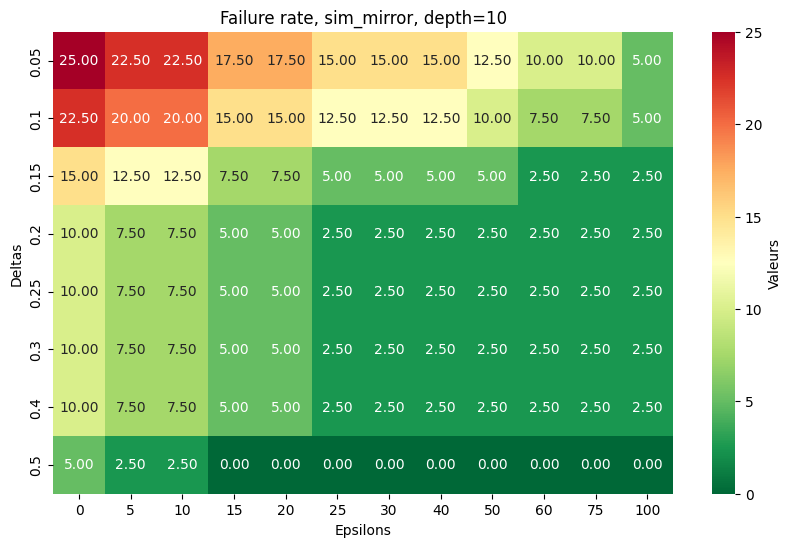

In [14]:
evas = main(dataset[0:40], 4000, 10,0) 
#last parameter --> type; 
#0 : mirror, 
#1 : sim_axis, 
#2 : sim_diag, 
#3 : better, 
#4 : first
tests(evas,0,10)

## Observations
### sim_mirror
Evaluations are stored in pickle files.
#### depth = 10, entire dataset

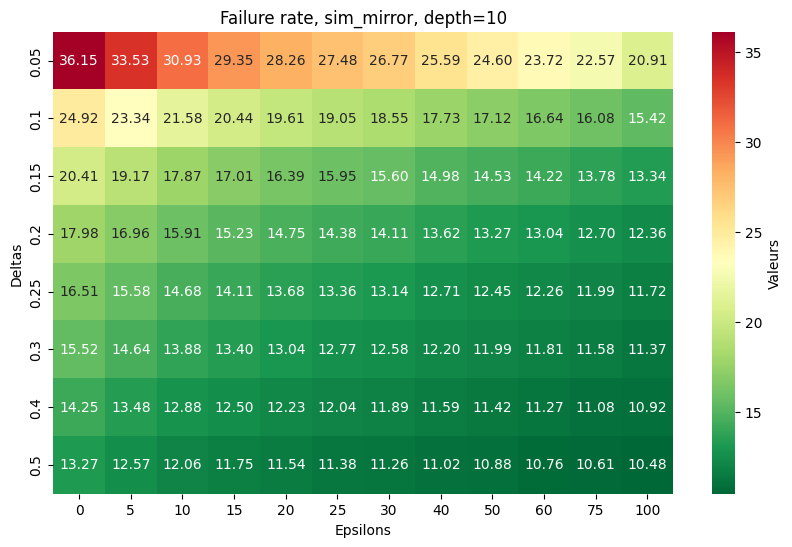

In [15]:
path = os.path.join('sim_mirror_d=10','evaluations50000_sim_mirror_d_10.pkl')
with open(path, 'rb') as file:
    evaluations50000_sim_mirror_d_10 = pickle.load(file)

tests(evaluations50000_sim_mirror_d_10,0,10)

#### depth = 15, entire dataset

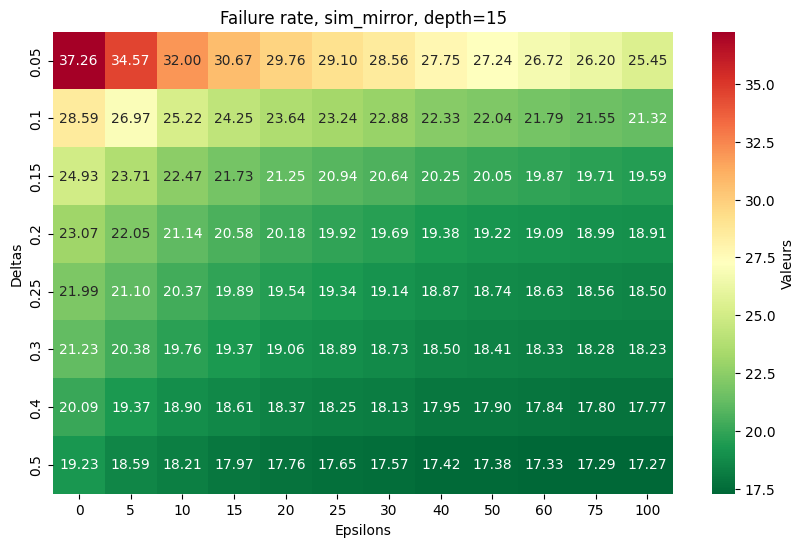

In [16]:
path = os.path.join('sim_mirror_d=15','evaluations50000_sim_mirror_d_15.pkl')
with open(path, 'rb') as file:
    evaluations50000_sim_mirror_d_15 = pickle.load(file)

tests(evaluations50000_sim_mirror_d_15,0,15)

#### depth = 20, entire dataset

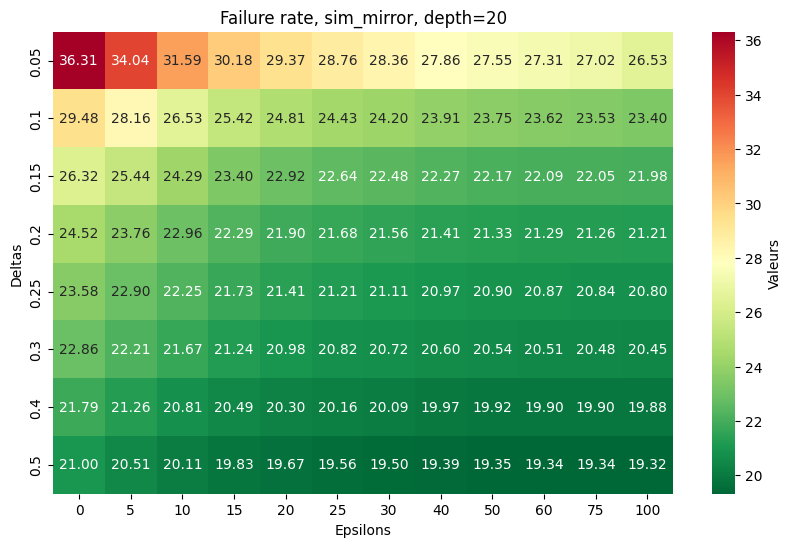

In [17]:
path = os.path.join('sim_mirror_d=20','evaluations50000_sim_mirror_d_20.pkl')
with open(path, 'rb') as file:
    evaluations50000_sim_mirror_d_20 = pickle.load(file)

tests(evaluations50000_sim_mirror_d_20,0,20)

We can observe that despite increasing the depth, the results are not getting better, we could even say that it is worsening. We also observed that with each position mutations. We decided to check positions that had important deviations on depth 10 (that we found by setting important thresholds) when evaluating their equivalent counterpart.
After checking many positions, we found that big differences are often observed when the advante for one side is big, in centipawns or when it is not far from a mate.
Examples :

In [18]:
pos1 = '1B4R1/7B/8/2K3n1/8/7k/R1r5/1B6 w'
pos2 = '1N5k/3Kb2q/1NP3p1/1R4B1/3R4/1B6/8/n3Q3 w'
show_pos([pos1,pos2],300)

print("pos1 : ",evaluationdouble(pos1,sim_mirror(pos1),50000,10))
print("pos2 : ",evaluationdouble(pos2,sim_axis(pos2),50000,10))

pos1 :  ({'type': 'mate', 'value': 9}, {'type': 'cp', 'value': -2101})
pos2 :  ({'type': 'cp', 'value': 7305}, {'type': 'cp', 'value': 2850})


It seems that Stockfish starts to return high values when the positions are not far from a mate. If we increase the depth, the second evaluation also indicate a mate:

In [19]:
print("pos1 : ",evaluationdouble(pos1,sim_mirror(pos1),50000,15))
print("pos2 : ",evaluationdouble(pos2,sim_axis(pos2),50000,15))

pos1 :  ({'type': 'mate', 'value': 6}, {'type': 'mate', 'value': -5})
pos2 :  ({'type': 'mate', 'value': 8}, {'type': 'mate', 'value': 7})


Reaching a certain depth, Stockfish returns the same values for both original and mutated positions.

In [20]:
print("pos1 : ",evaluationdouble(pos1,sim_mirror(pos1),50000,20))
print("pos2 : ",evaluationdouble(pos2,sim_axis(pos2),50000,20))

pos1 :  ({'type': 'mate', 'value': 5}, {'type': 'mate', 'value': -5})
pos2 :  ({'type': 'mate', 'value': 7}, {'type': 'mate', 'value': 7})


We have to notice that MRs will always detect a problem if the evaluations' types are different OR if they are a mate for both positions but their values are not exactly the same. It is therefore strange to observe that increasing the depth does not improve the rate of respected MRs, but it could explain why that much problem are detected. We then checked the biggest deviations with depth 15.

In [21]:
pos3 = '2N5/3k4/8/3B4/1K6/5n1r/8/4r3 b'
show_pos([pos3],300)
ev10 = evaluationdouble(pos3,sim_diag(pos3),50000,10)
print("pos3, d=10 : ", ev10, " - ", MR_equi(ev10[0],ev10[1],0.25,20))
ev15 = evaluationdouble(pos3,sim_diag(pos3),50000,15)
print("pos3, d=15 : ", ev15, " - ", MR_equi(ev15[0],ev15[1],0.25,20))
ev20 = evaluationdouble(pos3,sim_diag(pos3),50000,20)
print("pos3, d=20 : ", ev20, " - ", MR_equi(ev20[0],ev20[1],0.25,20))
ev25 = evaluationdouble(pos3,sim_diag(pos3),50000,25)
print("pos3, d=25 : ", ev25, " - ", MR_equi(ev25[0],ev25[1],0.25,20))
ev30 = evaluationdouble(pos3,sim_diag(pos3),50000,30)
print("pos3, d=30 : ", ev30, " - ", MR_equi(ev30[0],ev30[1],0.25,20))

pos3, d=10 :  ({'type': 'cp', 'value': -1088}, {'type': 'cp', 'value': -1114})  -  True
pos3, d=15 :  ({'type': 'cp', 'value': -5972}, {'type': 'cp', 'value': -1543})  -  False
pos3, d=20 :  ({'type': 'mate', 'value': -11}, {'type': 'mate', 'value': -18})  -  False
pos3, d=25 :  ({'type': 'mate', 'value': -9}, {'type': 'mate', 'value': -12})  -  False
pos3, d=30 :  ({'type': 'mate', 'value': -9}, {'type': 'mate', 'value': -9})  -  True


As we can see, positions with a big advantage for a side can have no problems when we use a low depth, then show big deviations when Stockfish starts to find a mate thanks to an increase in depth, and then converge when increasing the depth even more. That could explain why increasing the depth doesn't improbe our results, since the large majority of the positions in our dataset are random positions, many of them have a strange and unlikely arrangement of pieces, often leading to an overwhelming advantage for a side.
In the first time, we consequently decided to split positions where a mate is detected and positions where the difference is in centipawns.

#### Additional function

In [22]:
def split_mate_cp(evaluations):
    pos1s_mate = []
    pos2s_mate = []
    ev1s_mate = []
    ev2s_mate = []
    indexy_mate = []
    pos1s_cp = []
    pos2s_cp = []
    ev1s_cp = []
    ev2s_cp = []
    indexy_cp = []
    index_cp = 0
    index_mate = 0
    for index, eva in evaluations.iterrows():
        if type(eva['evaluation pos1'])==list:
            if eva['evaluation pos1'][0].get('Mate')!=None or eva['evaluation pos2'][0].get('type')!=None:
                indexy_mate.append(index_mate)
                index_mate+=1
                pos1s_mate.append(eva['pos1'])
                pos2s_mate.append(eva['pos2'])
                ev1s_mate.append(eva['evaluation pos1'])
                ev2s_mate.append(eva['evaluation pos2'])
            else:
                indexy_cp.append(index_mate)
                index_cp += 1
                pos1s_cp.append(eva['pos1'])
                pos2s_cp.append(eva['pos2'])
                ev1s_cp.append(eva['evaluation pos1'])
                ev2s_cp.append(eva['evaluation pos2'])
        elif eva['evaluation pos1'].get('type')=='mate' or eva['evaluation pos2'].get('type')=='mate':
            indexy_mate.append(index_mate)
            index_mate+=1
            pos1s_mate.append(eva['pos1'])
            pos2s_mate.append(eva['pos2'])
            ev1s_mate.append(eva['evaluation pos1'])
            ev2s_mate.append(eva['evaluation pos2'])
        else:
            indexy_cp.append(index_mate)
            index_cp += 1
            pos1s_cp.append(eva['pos1'])
            pos2s_cp.append(eva['pos2'])
            ev1s_cp.append(eva['evaluation pos1'])
            ev2s_cp.append(eva['evaluation pos2'])
    dmate = {'index': indexy_mate, 'pos1': pos1s_mate, 'evaluation pos1': ev1s_mate,
             'pos2': pos2s_mate, 'evaluation pos2': ev2s_mate}
    dcp = {'index': indexy_cp, 'pos1': pos1s_cp, 'evaluation pos1': ev1s_cp,
             'pos2': pos2s_cp, 'evaluation pos2': ev2s_cp}
    mate_evas = pd.DataFrame(data=dmate)
    cp_evas = pd.DataFrame(data=dcp)
    return cp_evas, mate_evas

#### depth = 10, splitting

We check the proportion of mate, and print the grids corresponding to the evaluations with a centipawns difference, then the ones with a mate, even though mate positions won't be affected by thresholds.

In [23]:
print("Mates proportion : ", len(split_mate_cp(evaluations50000_sim_mirror_d_10)[1])/(len(split_mate_cp(evaluations50000_sim_mirror_d_10)[0])+len(split_mate_cp(evaluations50000_sim_mirror_d_10)[1])))

Mates proportion :  0.283332682622106


##### Evaluations with a difference in centipawns

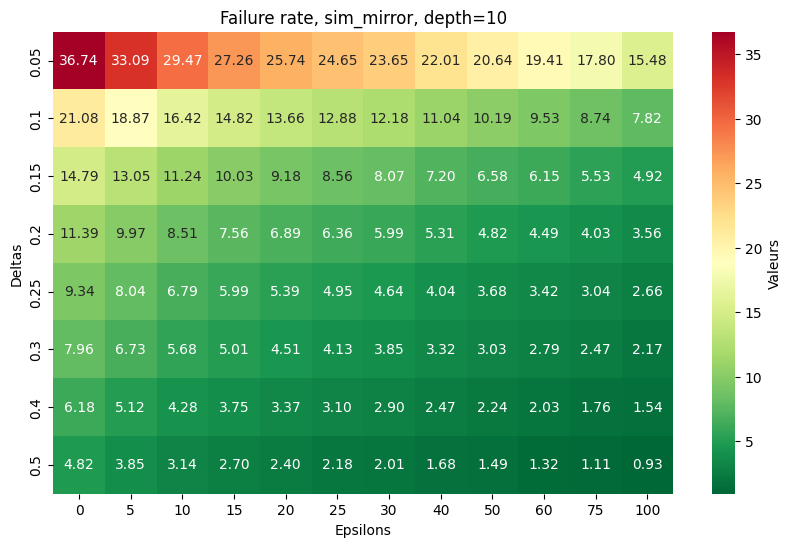

In [24]:
tests(split_mate_cp(evaluations50000_sim_mirror_d_10)[0],0,10)

##### Evaluations with a mate

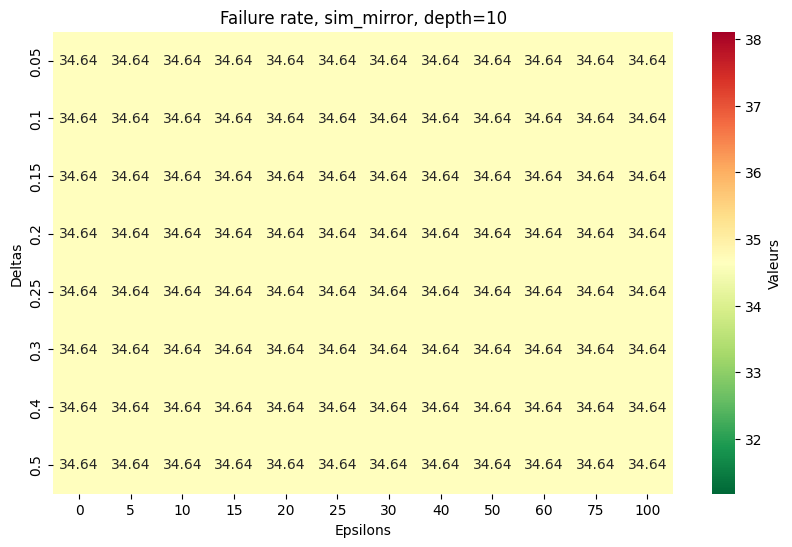

In [25]:
tests(split_mate_cp(evaluations50000_sim_mirror_d_10)[1],0,10)

As we said, mate positions are not affected by thresholds. Since 30.43% of the mate positions have problems detected by MRs, regardless of the thresholds every grid square sees its value affected by a 30.43% of failure rate with a weight of 26.6%. If we check only the positions with a difference in centipawns, we can see that many squares of the grid have now a way lower value than before.

Now we'll try to increase the depth.

#### depth = 15, splitting

In [26]:
print("Mates proportion : ", len(split_mate_cp(evaluations50000_sim_mirror_d_15)[1])/(len(split_mate_cp(evaluations50000_sim_mirror_d_15)[0])+len(split_mate_cp(evaluations50000_sim_mirror_d_15)[1])))

Mates proportion :  0.4397500976181179


The mates proportion became higher, which may be the reason why increasing the depth was not improving our results.

##### Evaluations with a difference in centipawns

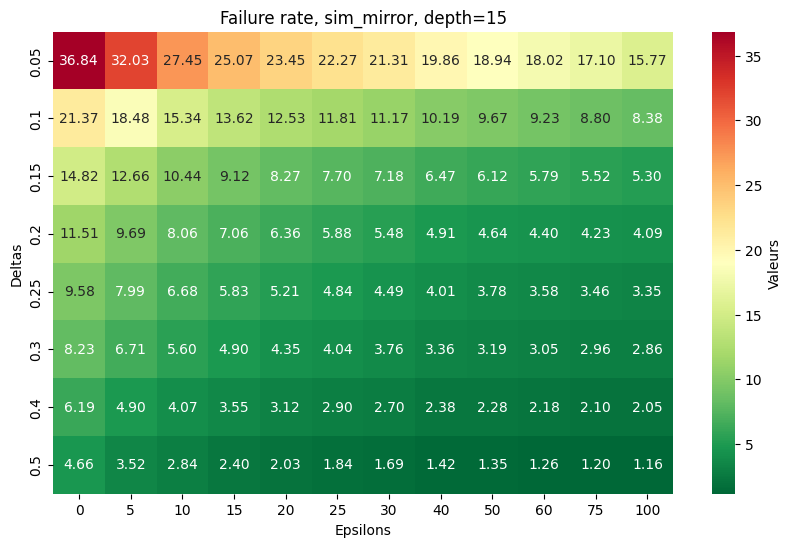

In [27]:
tests(split_mate_cp(evaluations50000_sim_mirror_d_15)[0],0,15)

##### Evaluations with a mate

In [28]:
print('Mates failure rate : ',100-MR(split_mate_cp(evaluations50000_sim_mirror_d_15)[1],0,1,1),'%')

Mates failure rate :  37.79968034096963 %


#### depth = 20, splitting

In [29]:
print("Mates proportion : ", len(split_mate_cp(evaluations50000_sim_mirror_d_20)[1])/(len(split_mate_cp(evaluations50000_sim_mirror_d_20)[0])+len(split_mate_cp(evaluations50000_sim_mirror_d_20)[1])))

Mates proportion :  0.5365958612056488


##### Evaluations with a difference in centipawns

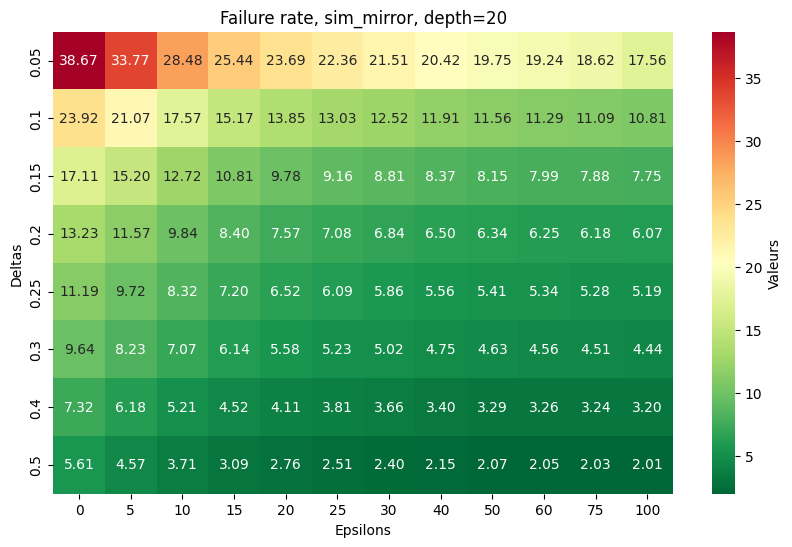

In [30]:
tests(split_mate_cp(evaluations50000_sim_mirror_d_20)[0],0,20)

##### Evaluations with a mate

In [31]:
print('Mates failure rate : ',100-MR(split_mate_cp(evaluations50000_sim_mirror_d_20)[1],0,1,1),'%')

Mates failure rate :  34.27863235401327 %


Increasing the depth did not improve our results, now we will make the grid for only the positions that were taken from real games. These positions are the 1234 last ones in our dataset.

#### depth = 10, real positions

In [32]:
#function to get real positions
def real_positions(evas):
    real = []
    real2 = []
    indexy = []
    ev1s = []
    ev2s = []
    index = 0
    real_pos = dataset[24768:]
    #indexent2 = 0
    for indexent, eva in evas.iterrows():
        for pos in real_pos:
            if eva['pos1'] == pos and eva['pos1'] not in real:
                #print(indexent - indexent2, index)
                #indexent2 = indexent
                indexy.append(index)
                index+=1
                real.append(eva['pos1'])
                real2.append(eva['pos2'])
                ev1s.append(eva['evaluation pos1'])
                ev2s.append(eva['evaluation pos2'])
    d = {'index': indexy, 'pos1': real, 'evaluation pos1': ev1s,
             'pos2': real2, 'evaluation pos2': ev2s} 
    df = pd.DataFrame(data=d)
    return df
                
    

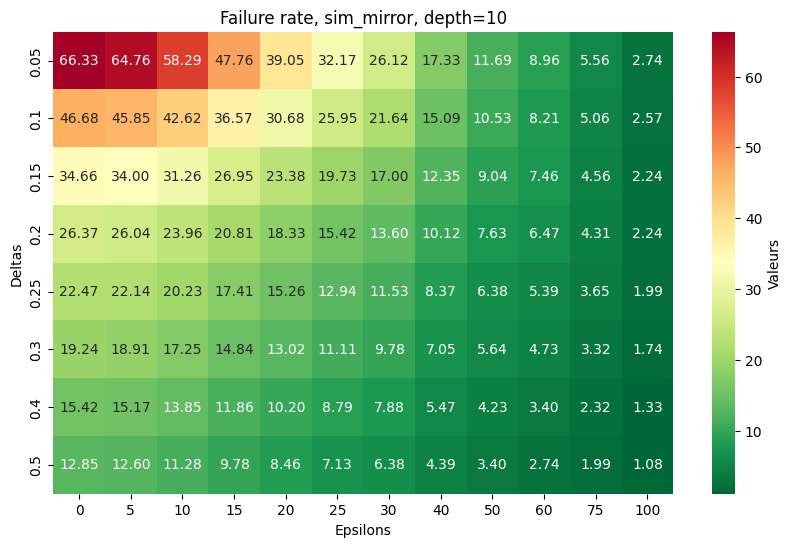

In [33]:
evaluations50000_sim_mirror_d_10_real = real_positions(evaluations50000_sim_mirror_d_10[24000:])
evaluations50000_sim_mirror_d_10_real.reset_index(drop=True, inplace=True)
tests(evaluations50000_sim_mirror_d_10_real,0,10)

#### depth = 15, real positions

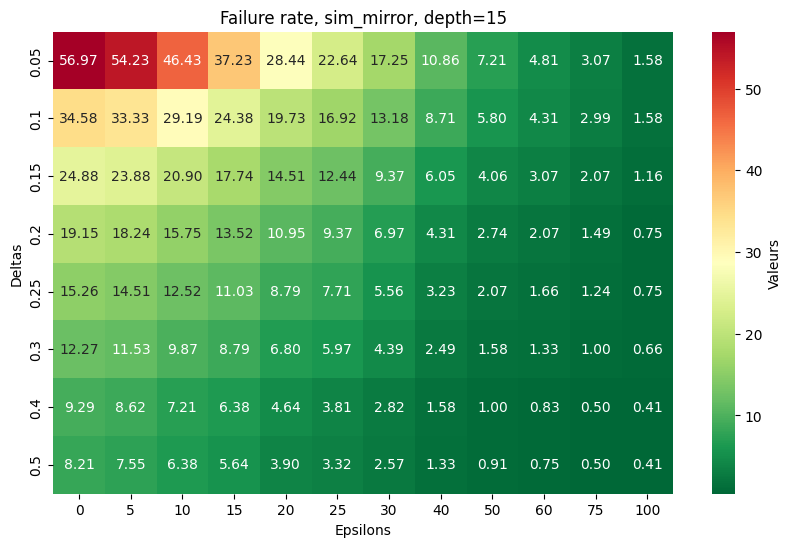

In [34]:
evaluations50000_sim_mirror_d_15_real = real_positions(evaluations50000_sim_mirror_d_15[24000:])
evaluations50000_sim_mirror_d_15_real.reset_index(drop=True, inplace=True)
tests(evaluations50000_sim_mirror_d_15_real,0,15)

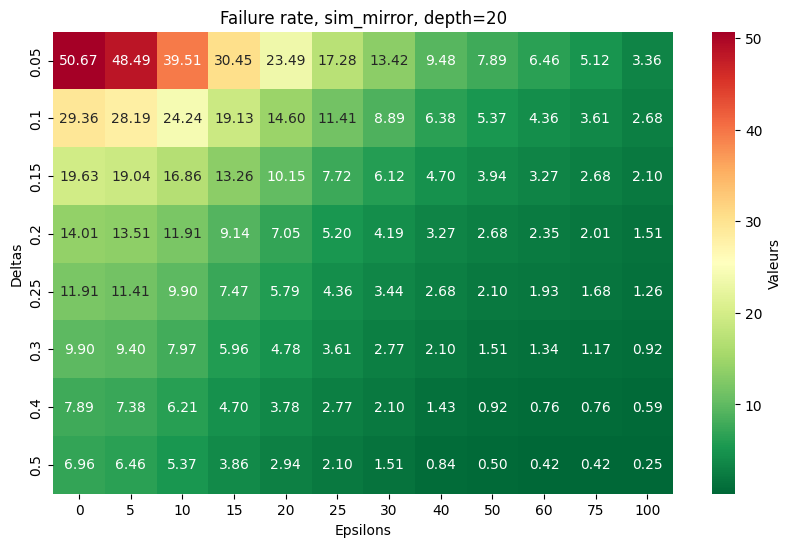

In [35]:
evaluations50000_sim_mirror_d_20_real = real_positions(evaluations50000_sim_mirror_d_20[24000:])
evaluations50000_sim_mirror_d_20_real.reset_index(drop=True, inplace=True)
tests(evaluations50000_sim_mirror_d_20_real,0,20)

On plausible positions, we an see that beside for the tightest thresholds, the number of problems detected by the MRs are way lower, and increasing the depth is now improving our results. We can explain the increase in detected problems for tight thresholds with the fact that on real positions, centipawns values tend to be really lower than before. If for instance, we have a position with an evaluation with a centipawns value of 5 (meaning an advantage of 0.05 for White), and its mirrored version gets an evaluation with a centipawns value of -7 (meaning an advantage of 0.07 for Black), the delta value will be abs((5-7)/(5+7)) = 0.17, which is superior to 0.05. Since the centipawns difference is not equal to 0, the MRs will detect a problem, even though the difference is meaningless.

### sim_axis

#### depth = 10, entire dataset

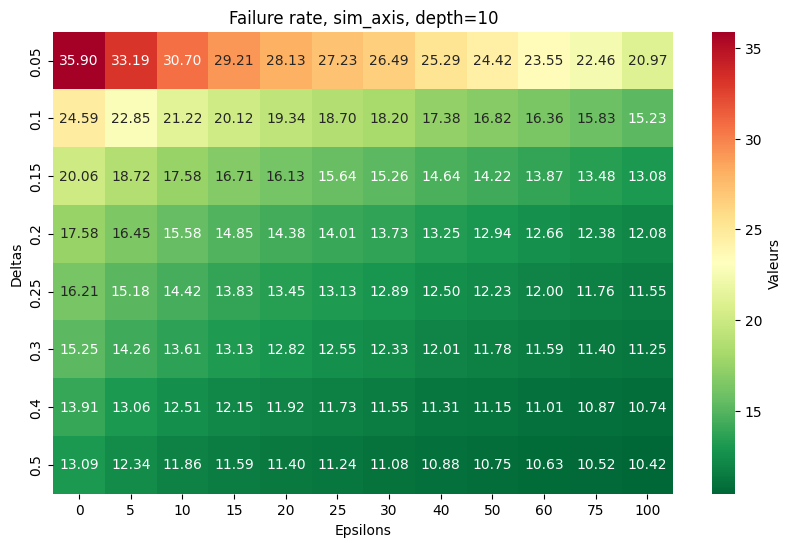

In [36]:
path = os.path.join('sim_axis_d=10','evaluations50000_sim_axis_d_10.pkl')
with open(path, 'rb') as file:
    evaluations50000_sim_axis_d_10 = pickle.load(file)

tests(evaluations50000_sim_axis_d_10,1,10)

#### depth = 10, splitting

In [37]:
print("Mates proportion : ", len(split_mate_cp(evaluations50000_sim_axis_d_10)[1])/(len(split_mate_cp(evaluations50000_sim_axis_d_10)[0])+len(split_mate_cp(evaluations50000_sim_axis_d_10)[1])))

Mates proportion :  0.28385690373311534


##### Evaluations with a difference in centipawns

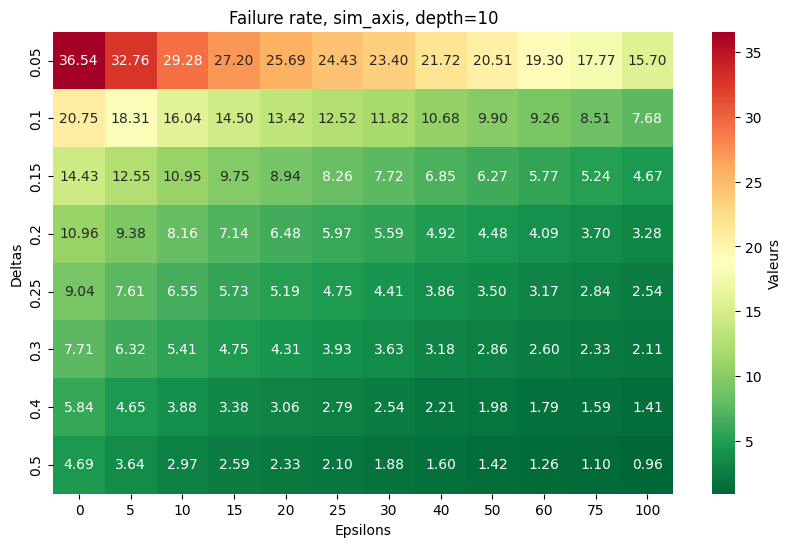

In [38]:
tests(split_mate_cp(evaluations50000_sim_axis_d_10)[0],1,10)

##### Evaluations with a mate

In [39]:
print('Mates failure rate : ',100-MR(split_mate_cp(evaluations50000_sim_axis_d_10)[1],1,1,1),'%')

Mates failure rate :  34.28414701042239 %


#### depth = 10, real positions

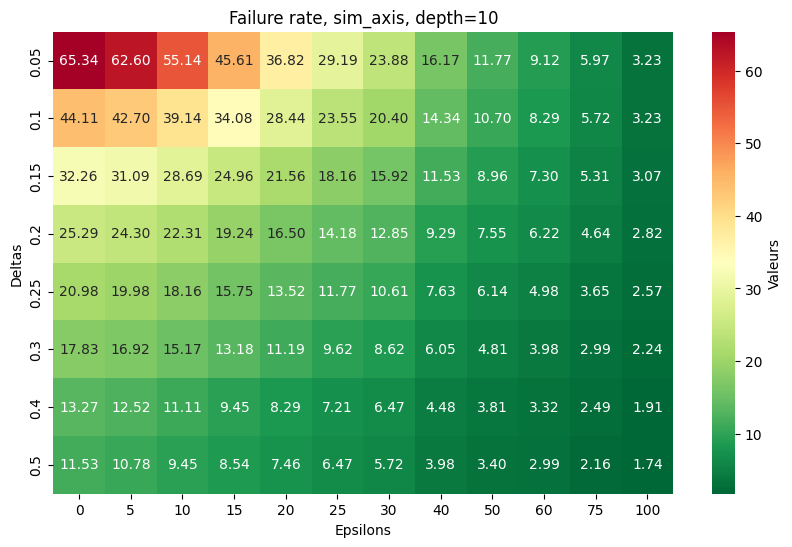

In [40]:
evaluations50000_sim_axis_d_10_real = real_positions(evaluations50000_sim_axis_d_10[24000:])
evaluations50000_sim_axis_d_10_real.reset_index(drop=True, inplace=True)
tests(evaluations50000_sim_axis_d_10_real,1,10)

#### depth = 15, entire dataset

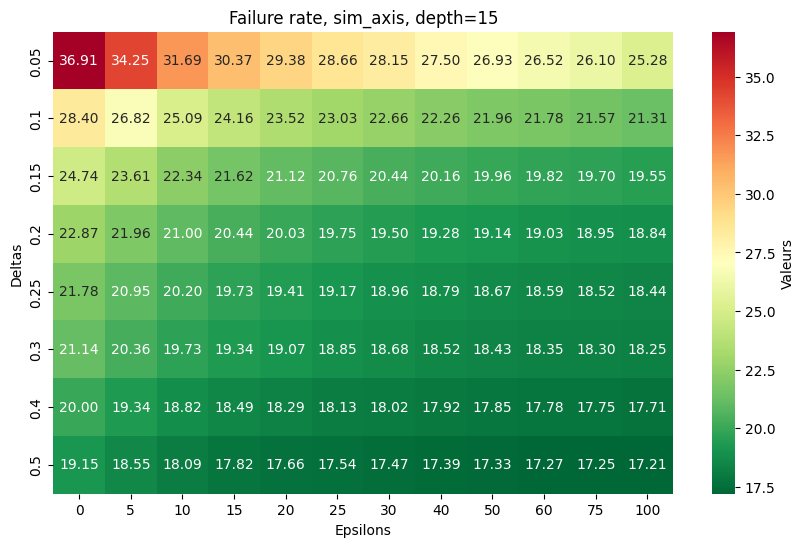

In [41]:
path = os.path.join('sim_axis_d=15','evaluations50000_sim_axis_d_15.pkl')
with open(path, 'rb') as file:
    evaluations50000_sim_axis_d_15 = pickle.load(file)

tests(evaluations50000_sim_axis_d_15,1,15)

#### depth = 15, splitting

In [42]:
print("Mates proportion : ", len(split_mate_cp(evaluations50000_sim_axis_d_15)[1])/(len(split_mate_cp(evaluations50000_sim_axis_d_15)[0])+len(split_mate_cp(evaluations50000_sim_axis_d_15)[1])))

Mates proportion :  0.44193560945225213


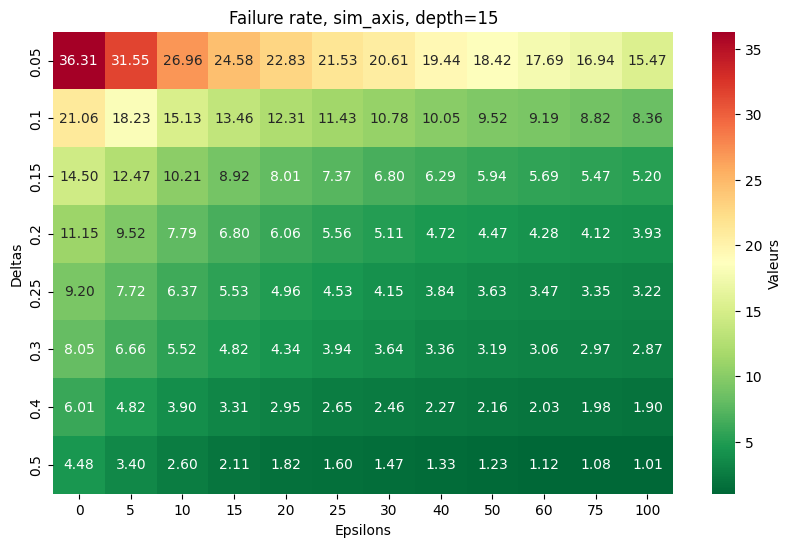

In [43]:
tests(split_mate_cp(evaluations50000_sim_axis_d_15)[0],1,15)

In [44]:
print('Mates failure rate : ',100-MR(split_mate_cp(evaluations50000_sim_axis_d_15)[1],1,1,1),'%')

Mates failure rate :  37.66737138830162 %


#### depth = 15, real positions

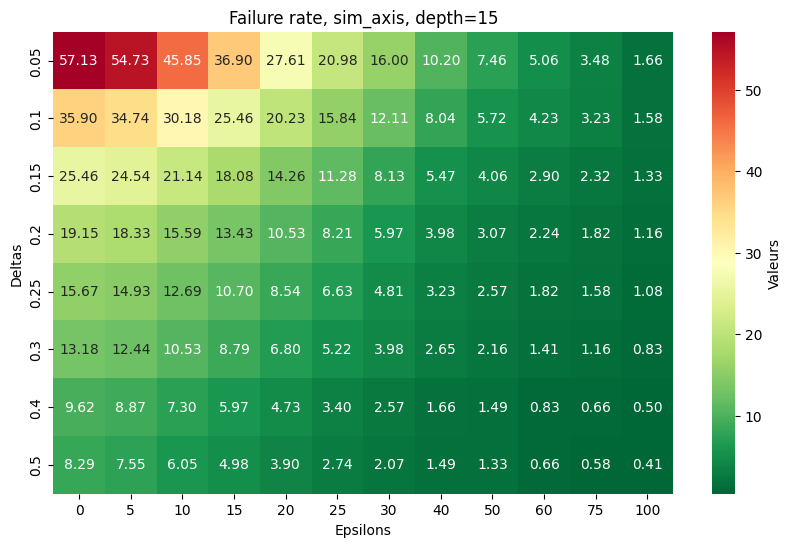

In [45]:
evaluations50000_sim_axis_d_15_real = real_positions(evaluations50000_sim_axis_d_15[24000:])
evaluations50000_sim_axis_d_15_real.reset_index(drop=True, inplace=True)
tests(evaluations50000_sim_axis_d_15_real,1,15)

#### depth = 20, entire dataset

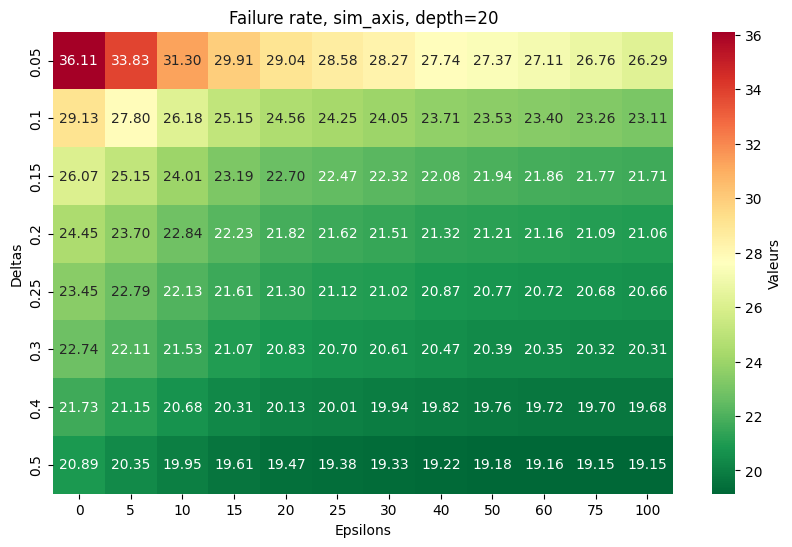

In [46]:
path = os.path.join('sim_axis_d=20','evaluations50000_sim_axis_d_20.pkl')
with open(path, 'rb') as file:
    evaluations50000_sim_axis_d_20 = pickle.load(file)

tests(evaluations50000_sim_axis_d_20,1,20)

#### depth = 20, splitting

In [47]:
print("Mates proportion : ", len(split_mate_cp(evaluations50000_sim_axis_d_20)[1])/(len(split_mate_cp(evaluations50000_sim_axis_d_20)[0])+len(split_mate_cp(evaluations50000_sim_axis_d_20)[1])))

Mates proportion :  0.5357728017476788


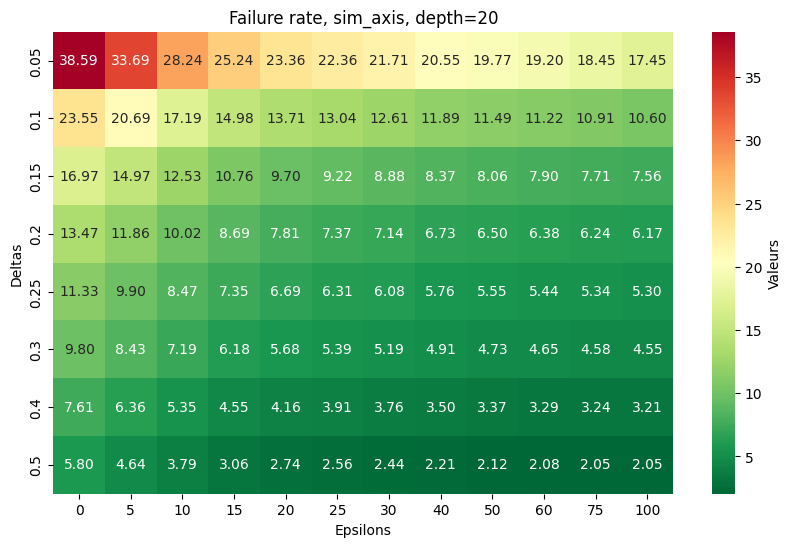

In [48]:
tests(split_mate_cp(evaluations50000_sim_axis_d_20)[0],1,20)

In [49]:
print('Mates failure rate : ',100-MR(split_mate_cp(evaluations50000_sim_axis_d_20)[1],1,1,1),'%')

Mates failure rate :  33.95951652832386 %


#### depth = 20, real positions

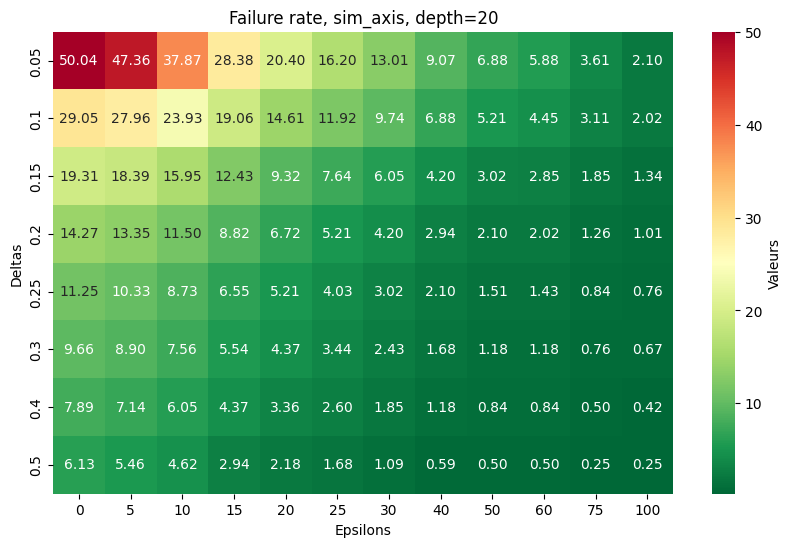

In [50]:
evaluations50000_sim_axis_d_20_real = real_positions(evaluations50000_sim_axis_d_20[24000:])
evaluations50000_sim_axis_d_20_real.reset_index(drop=True, inplace=True)
tests(evaluations50000_sim_axis_d_20_real,1,20)

### sim_diag

#### depth = 10, entire dataset

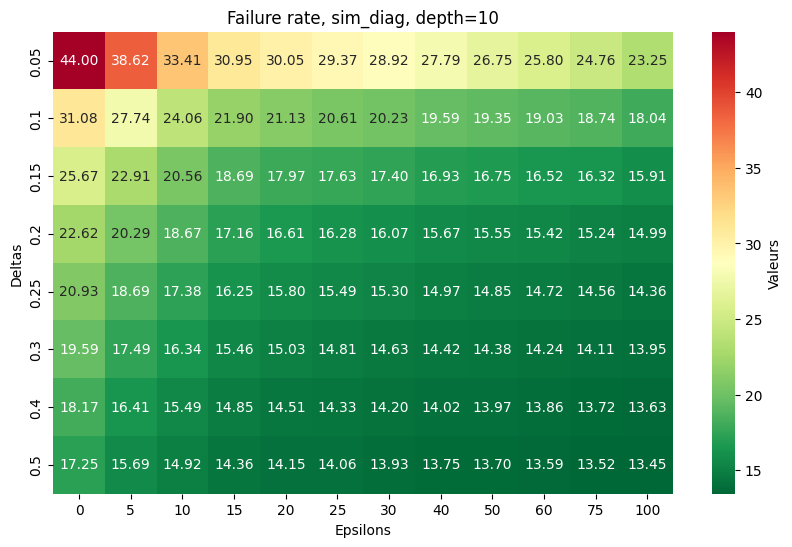

In [51]:
path = os.path.join('sim_diag_d=10','evaluations50000_sim_diag_d_10.pkl')
with open(path, 'rb') as file:
    evaluations50000_sim_diag_d_10 = pickle.load(file)

tests(evaluations50000_sim_diag_d_10,2,10)

#### depth = 10, splitting

In [52]:
print("Mates proportion : ", len(split_mate_cp(evaluations50000_sim_diag_d_10)[1])/(len(split_mate_cp(evaluations50000_sim_diag_d_10)[0])+len(split_mate_cp(evaluations50000_sim_diag_d_10)[1])))

Mates proportion :  0.3148984198645598


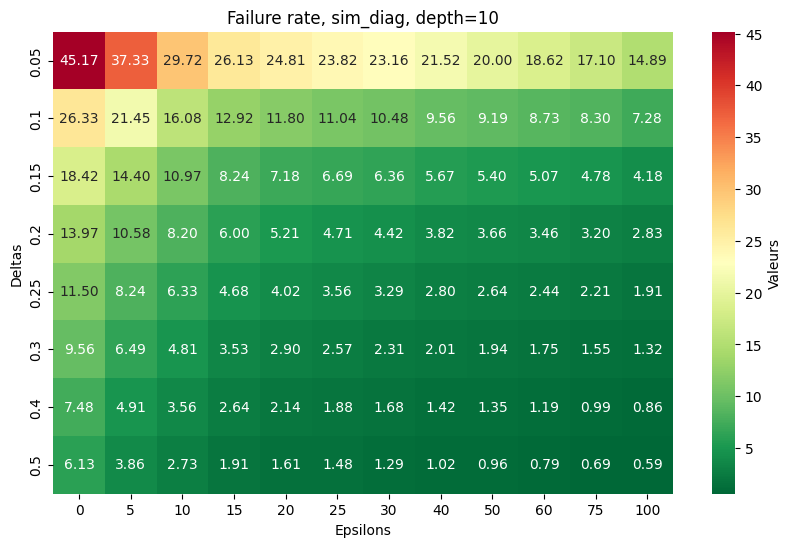

In [53]:
tests(split_mate_cp(evaluations50000_sim_diag_d_10)[0],2,10)

In [54]:
print('Mates failure rate : ',100-MR(split_mate_cp(evaluations50000_sim_diag_d_10)[1],2,1,1),'%')

Mates failure rate :  41.43369175627241 %


#### depth = 10, real positions

Since this mutation only works on positions without any pawn, its interest on real positions is deeply lowered. Furthermore, our dataset doesn't contain real positions with no pawn.

In [55]:
len(real_positions(evaluations50000_sim_diag_d_10))

0

#### depth = 15, entire dataset

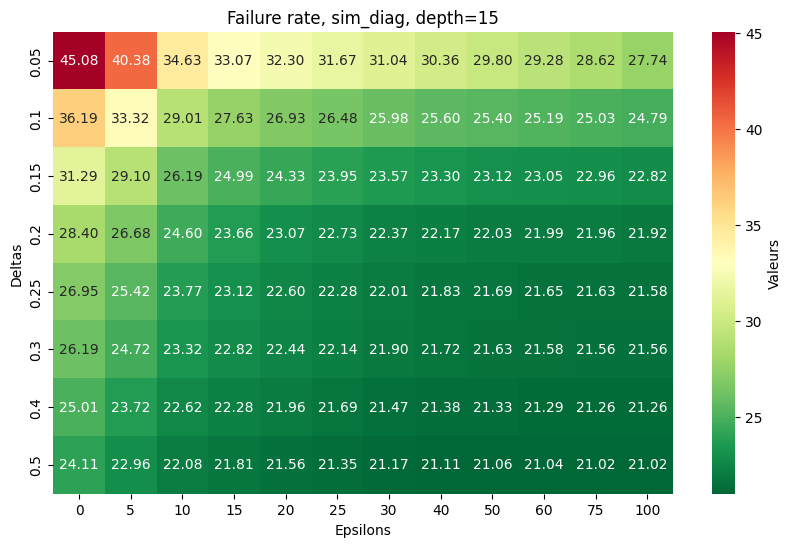

In [56]:
path = os.path.join('sim_diag_d=15','evaluations50000_sim_diag_d_15.pkl')
with open(path, 'rb') as file:
    evaluations50000_sim_diag_d_15 = pickle.load(file)

tests(evaluations50000_sim_diag_d_15,2,15)

#### depth = 15, splitting

In [57]:
print("Mates proportion : ", len(split_mate_cp(evaluations50000_sim_diag_d_15)[1])/(len(split_mate_cp(evaluations50000_sim_diag_d_15)[0])+len(split_mate_cp(evaluations50000_sim_diag_d_15)[1])))

Mates proportion :  0.46772009029345374


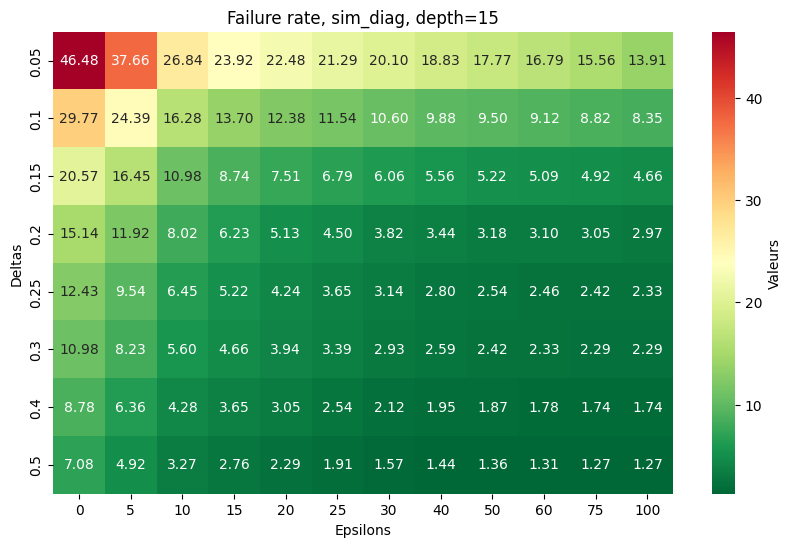

In [58]:
tests(split_mate_cp(evaluations50000_sim_diag_d_15)[0],2,15)

In [59]:
print('Mates failure rate : ',100-MR(split_mate_cp(evaluations50000_sim_diag_d_15)[1],2,1,1),'%')

Mates failure rate :  43.48455598455598 %


#### depth = 20, entire dataset

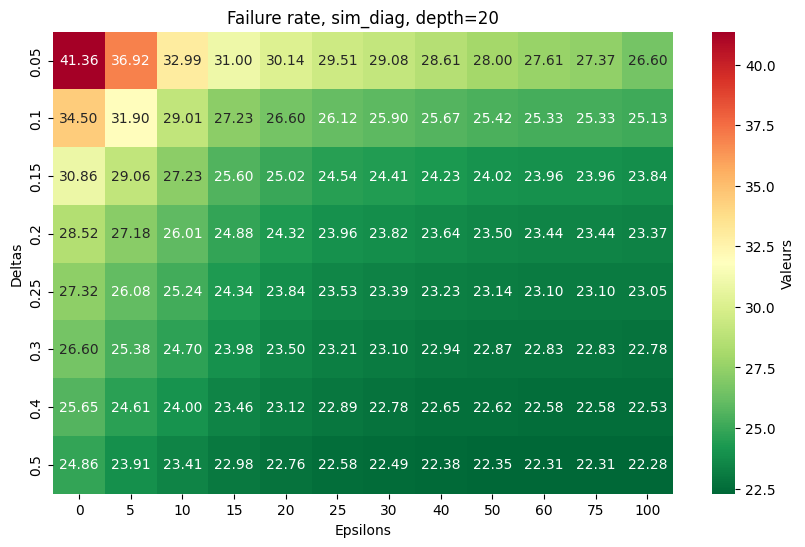

In [60]:
path = os.path.join('sim_diag_d=20','evaluations50000_sim_diag_d_20.pkl')
with open(path, 'rb') as file:
    evaluations50000_sim_diag_d_20 = pickle.load(file)

tests(evaluations50000_sim_diag_d_20,2,20)

#### depth = 20, splitting

In [61]:
print("Mates proportion : ", len(split_mate_cp(evaluations50000_sim_diag_d_20)[1])/(len(split_mate_cp(evaluations50000_sim_diag_d_20)[0])+len(split_mate_cp(evaluations50000_sim_diag_d_20)[1])))

Mates proportion :  0.5502370738315647


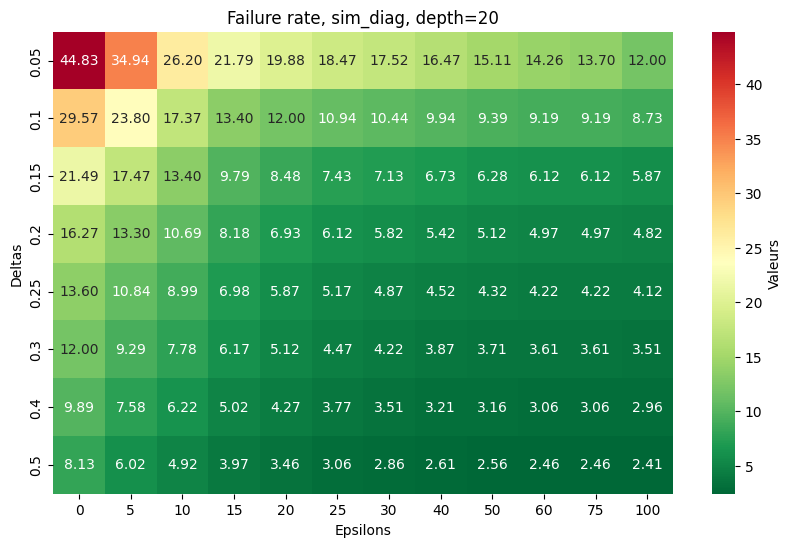

In [62]:
tests(split_mate_cp(evaluations50000_sim_diag_d_20)[0],2,20)

In [63]:
print('Mates failure rate : ',100-MR(split_mate_cp(evaluations50000_sim_diag_d_20)[1],2,1,1),'%')

Mates failure rate :  38.53098071399261 %


### replace

#### depth = 10, entire dataset

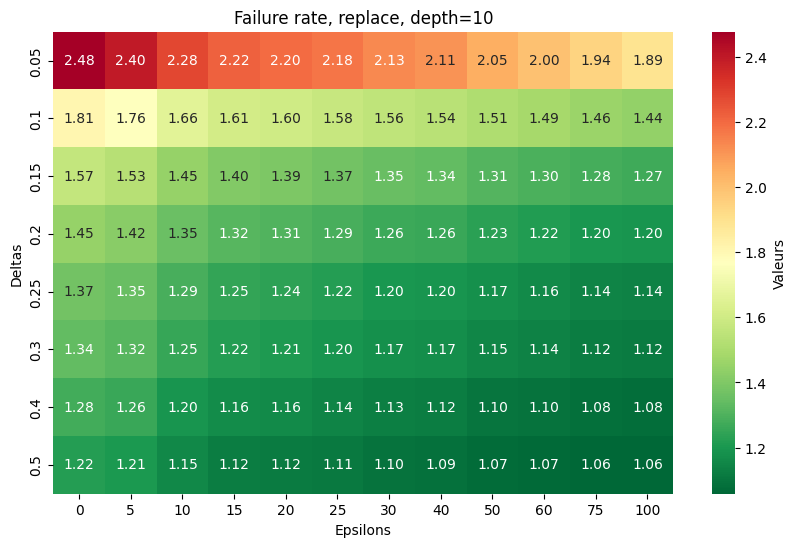

In [64]:
path = os.path.join('replace_d=10','evaluations50000_replace_d_10.pkl')
with open(path, 'rb') as file:
    evaluations50000_replace_d_10 = pickle.load(file)

tests(evaluations50000_replace_d_10,3,10)

#### depth = 10, splitting

In [65]:
print("Mates proportion : ", len(split_mate_cp(evaluations50000_replace_d_10)[1])/(len(split_mate_cp(evaluations50000_replace_d_10)[0])+len(split_mate_cp(evaluations50000_replace_d_10)[1])))

Mates proportion :  0.43926964805504104


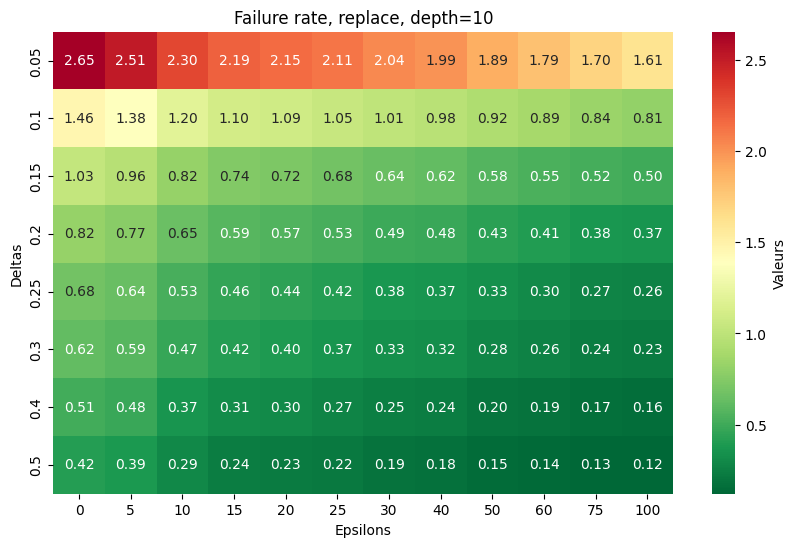

In [66]:
tests(split_mate_cp(evaluations50000_replace_d_10)[0],3,10)

In [67]:
print('Mates failure rate : ',100-MR(split_mate_cp(evaluations50000_replace_d_10)[1],3,1,1),'%')

Mates failure rate :  2.2530120481927725 %


#### depth = 10, real positions

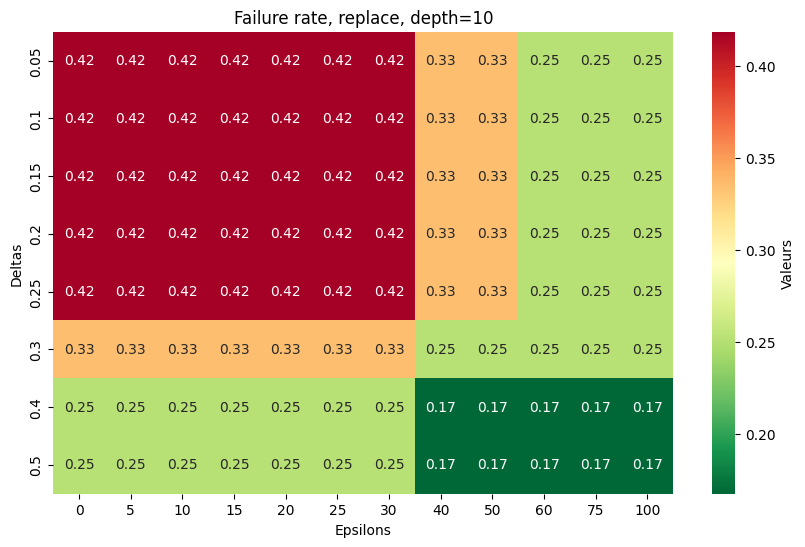

In [68]:
evaluations50000_replace_d_10_real = real_positions(evaluations50000_replace_d_10[17000:])
evaluations50000_replace_d_10_real.reset_index(drop=True, inplace=True)
tests(evaluations50000_replace_d_10_real,3,10)

#### depth = 15, entire dataset

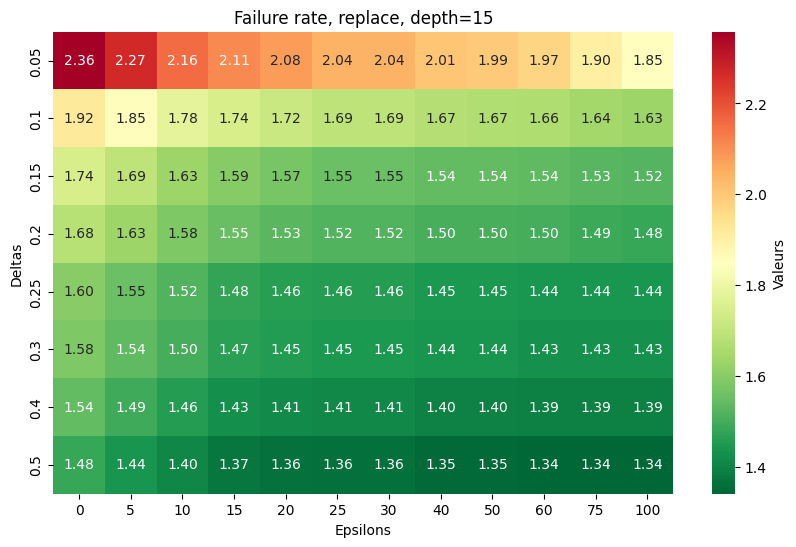

In [69]:
path = os.path.join('replace_d=15','evaluations50000_replace_d_15.pkl')
with open(path, 'rb') as file:
    evaluations50000_replace_d_15 = pickle.load(file)

tests(evaluations50000_replace_d_15,3,15)

#### depth = 15, splitting

In [70]:
print("Mates proportion : ", len(split_mate_cp(evaluations50000_replace_d_15)[1])/(len(split_mate_cp(evaluations50000_replace_d_15)[0])+len(split_mate_cp(evaluations50000_replace_d_15)[1])))

Mates proportion :  0.6127066553624417


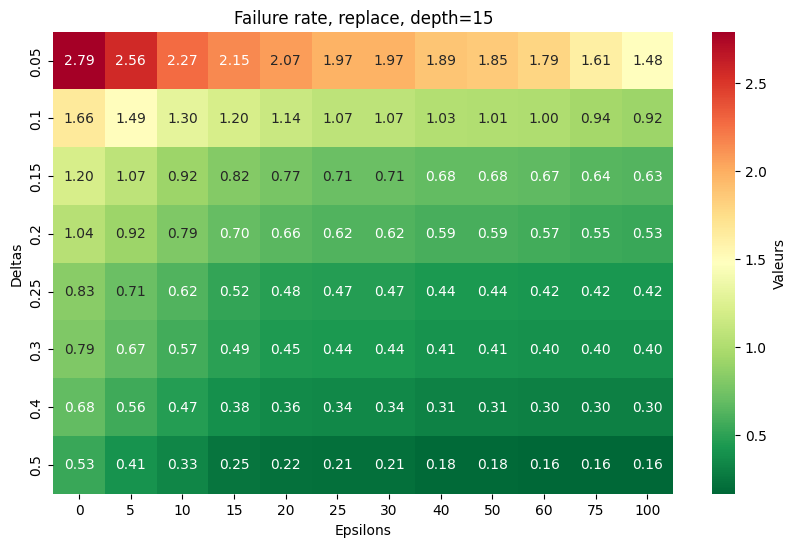

In [71]:
tests(split_mate_cp(evaluations50000_replace_d_15)[0],3,15)

In [72]:
print('Mates failure rate : ',100-MR(split_mate_cp(evaluations50000_replace_d_15)[1],3,1,1),'%')

Mates failure rate :  2.084234195278043 %


#### depth = 15, real positions

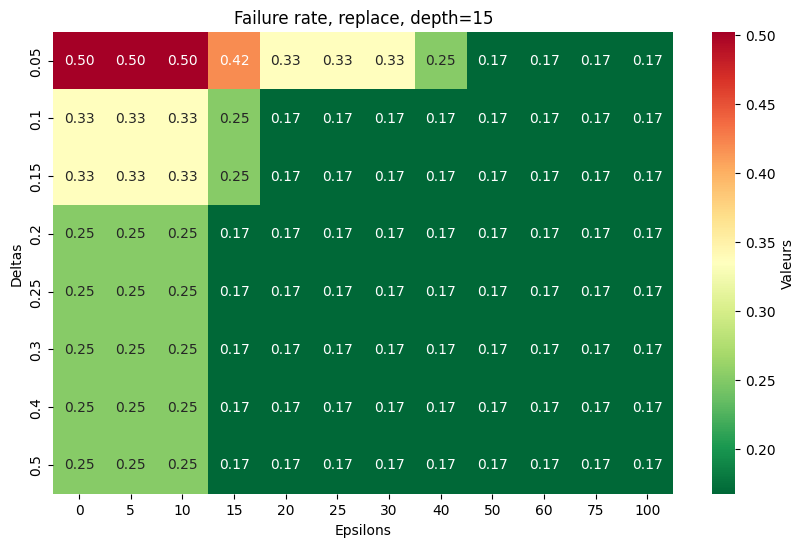

In [73]:
evaluations50000_replace_d_15_real = real_positions(evaluations50000_replace_d_15[17000:])
evaluations50000_replace_d_15_real.reset_index(drop=True, inplace=True)
tests(evaluations50000_replace_d_15_real,3,15)

#### depth = 20, entire dataset

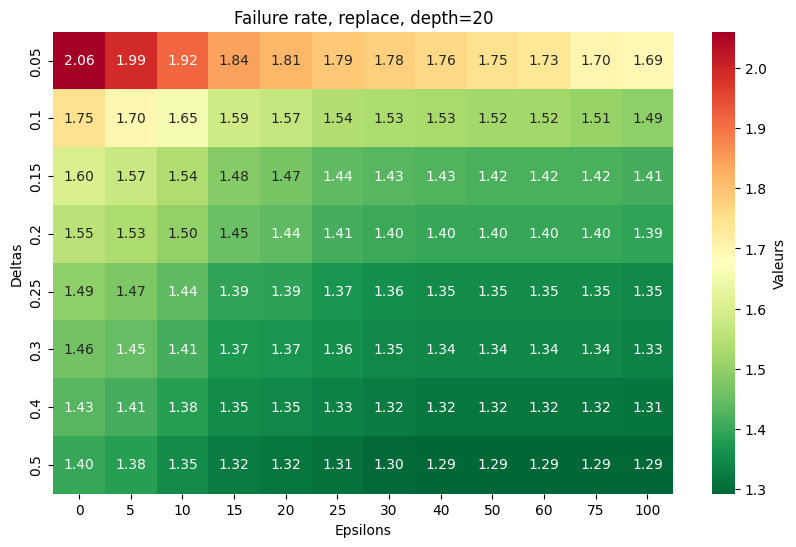

In [74]:
path = os.path.join('replace_d=20','evaluations50000_replace_d_20.pkl')
with open(path, 'rb') as file:
    evaluations50000_replace_d_20 = pickle.load(file)

tests(evaluations50000_replace_d_20,3,20)

#### depth = 20, splitting

In [75]:
print("Mates proportion : ", len(split_mate_cp(evaluations50000_replace_d_20)[1])/(len(split_mate_cp(evaluations50000_replace_d_20)[0])+len(split_mate_cp(evaluations50000_replace_d_20)[1])))

Mates proportion :  0.7085891208028613


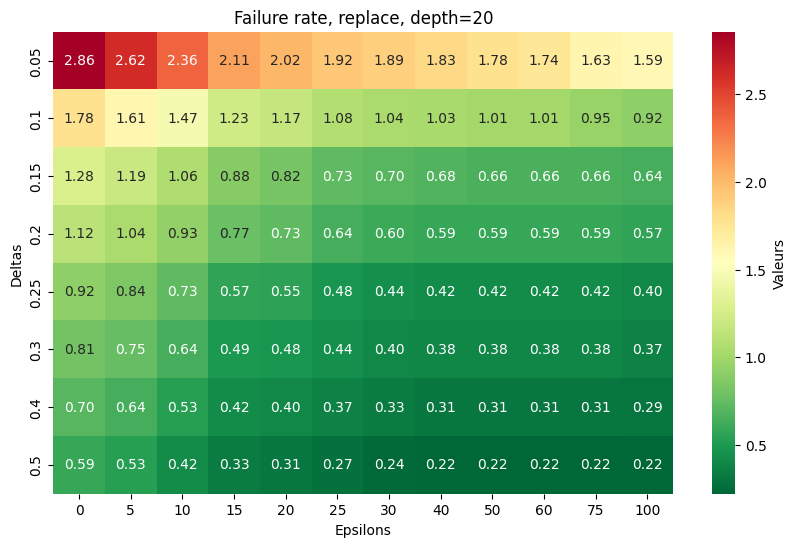

In [76]:
tests(split_mate_cp(evaluations50000_replace_d_20)[0],3,20)

In [77]:
print('Mates failure rate : ',100-MR(split_mate_cp(evaluations50000_replace_d_20)[1],3,1,1),'%')

Mates failure rate :  1.7327105620009036 %


#### depth = 20, real positions

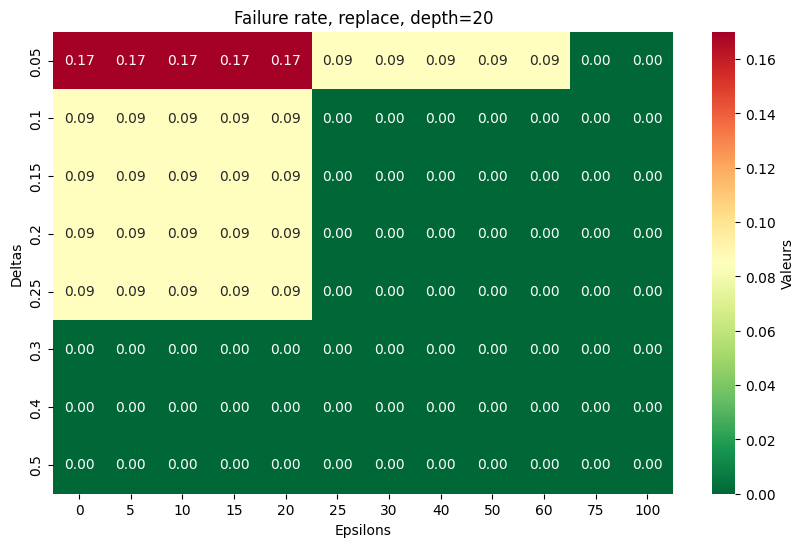

In [78]:
evaluations50000_replace_d_20_real = real_positions(evaluations50000_replace_d_20[17000:])
evaluations50000_replace_d_20_real.reset_index(drop=True, inplace=True)
tests(evaluations50000_replace_d_20_real,3,20)

### best_move

In this part, we are using sim_axis then taking the evaluation after the best move (according to Stockfish) is played.

#### depth = 10, entire dataset

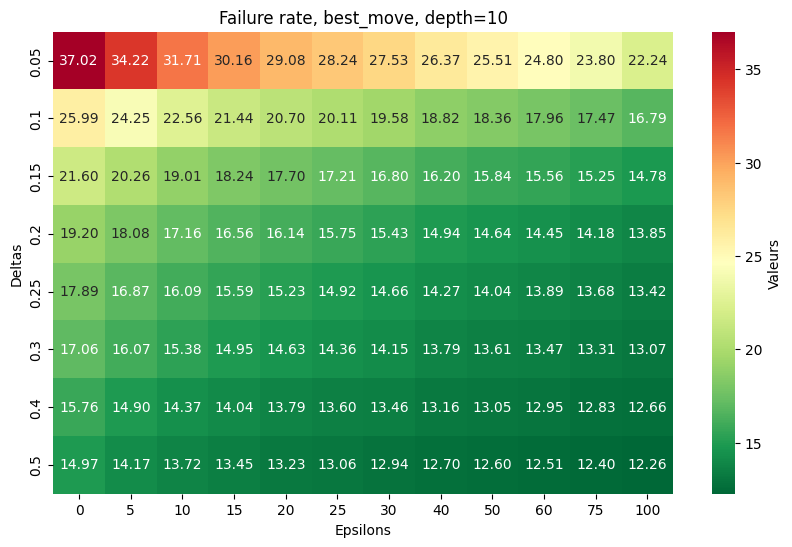

In [79]:
path = os.path.join('best_move_d=10','evaluations50000_best_move_d_10.pkl')
with open(path, 'rb') as file:
    evaluations50000_best_move_d_10 = pickle.load(file)

tests(evaluations50000_best_move_d_10,4,10)

#### depth = 10, splitting

In [80]:
print("Mates proportion : ", len(split_mate_cp(evaluations50000_best_move_d_10)[1])/(len(split_mate_cp(evaluations50000_best_move_d_10)[0])+len(split_mate_cp(evaluations50000_best_move_d_10)[1])))

Mates proportion :  0.28685196136408436


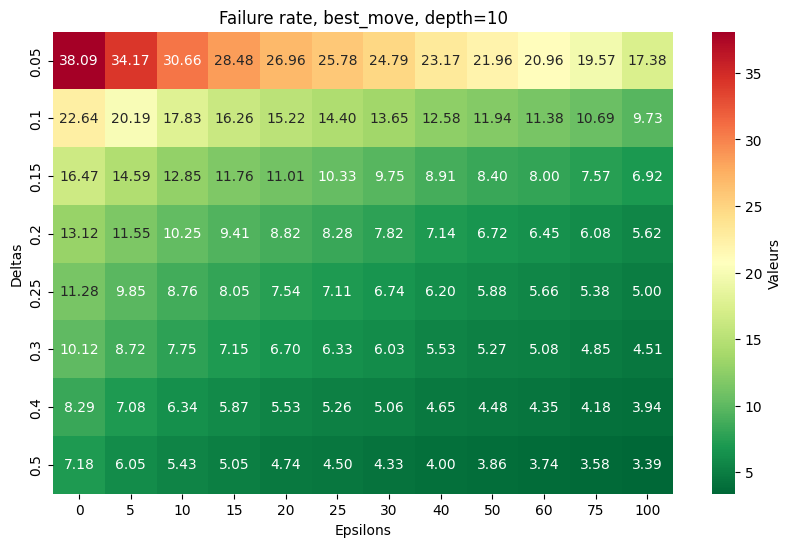

In [81]:
tests(split_mate_cp(evaluations50000_best_move_d_10)[0],4,10)

In [82]:
print('Mates failure rate : ',100-MR(split_mate_cp(evaluations50000_best_move_d_10)[1],4,1,1),'%')

Mates failure rate :  34.33205057724025 %


#### depth = 10, real positions

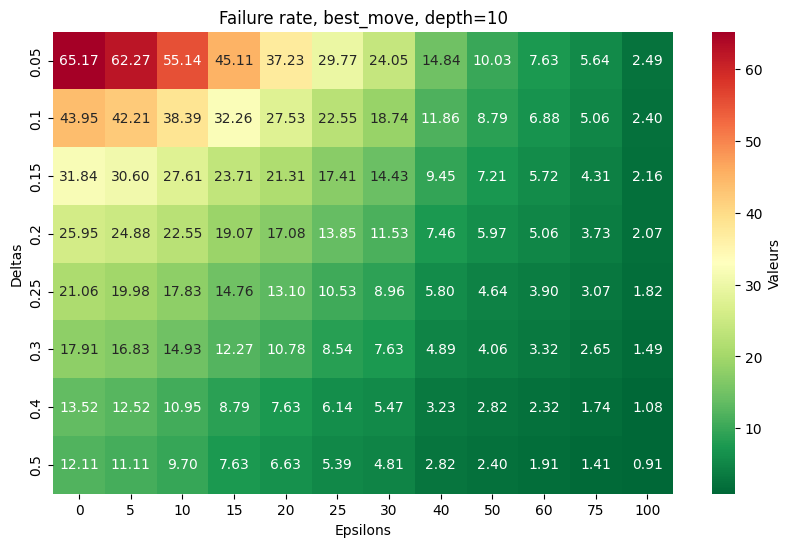

In [83]:
evaluations50000_best_move_d_10_real = real_positions(evaluations50000_best_move_d_10[24000:])
evaluations50000_best_move_d_10_real.reset_index(drop=True, inplace=True)
tests(evaluations50000_best_move_d_10_real,4,10)

#### depth = 15, entire dataset

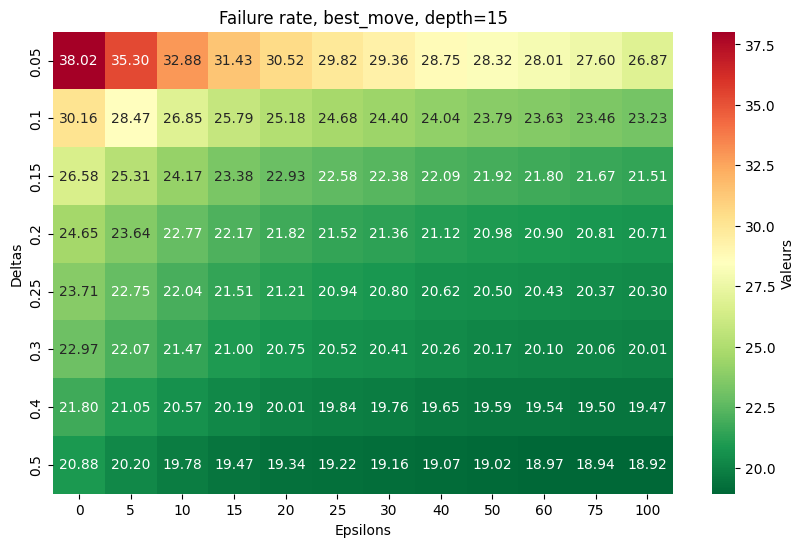

In [84]:
path = os.path.join('best_move_d=15','evaluations50000_best_move_d_15.pkl')
with open(path, 'rb') as file:
    evaluations50000_best_move_d_15 = pickle.load(file)

tests(evaluations50000_best_move_d_15,4,15)

#### depth = 15, splitting

In [85]:
print("Mates proportion : ", len(split_mate_cp(evaluations50000_best_move_d_15)[1])/(len(split_mate_cp(evaluations50000_best_move_d_15)[0])+len(split_mate_cp(evaluations50000_best_move_d_15)[1])))

Mates proportion :  0.43591057840160863


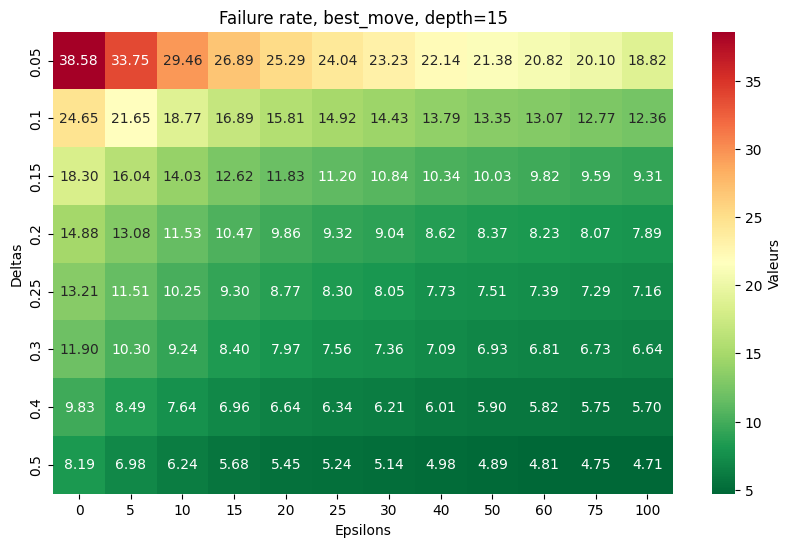

In [86]:
tests(split_mate_cp(evaluations50000_best_move_d_15)[0],4,15)

In [87]:
print('Mates failure rate : ',100-MR(split_mate_cp(evaluations50000_best_move_d_15)[1],4,1,1),'%')

Mates failure rate :  37.30101302460203 %


#### depth = 15, real positions

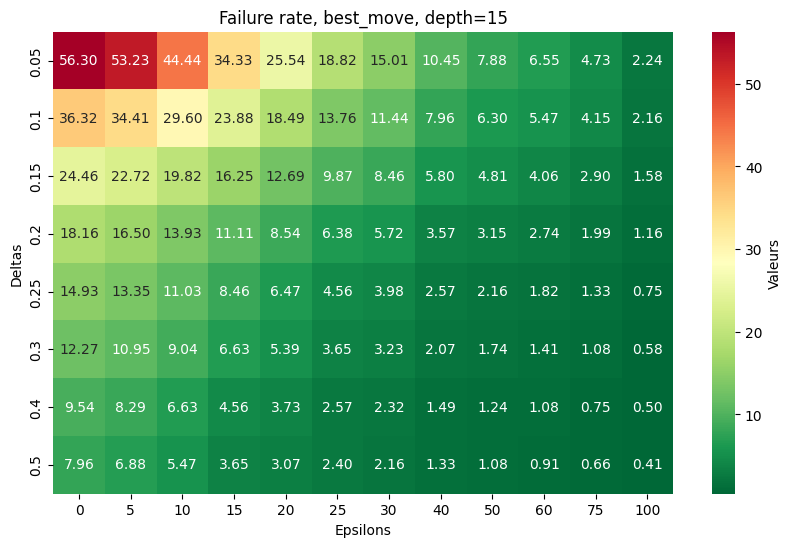

In [88]:
evaluations50000_best_move_d_15_real = real_positions(evaluations50000_best_move_d_15[24000:])
evaluations50000_best_move_d_15_real.reset_index(drop=True, inplace=True)
tests(evaluations50000_best_move_d_15_real,4,15)

#### depth = 20, entire dataset

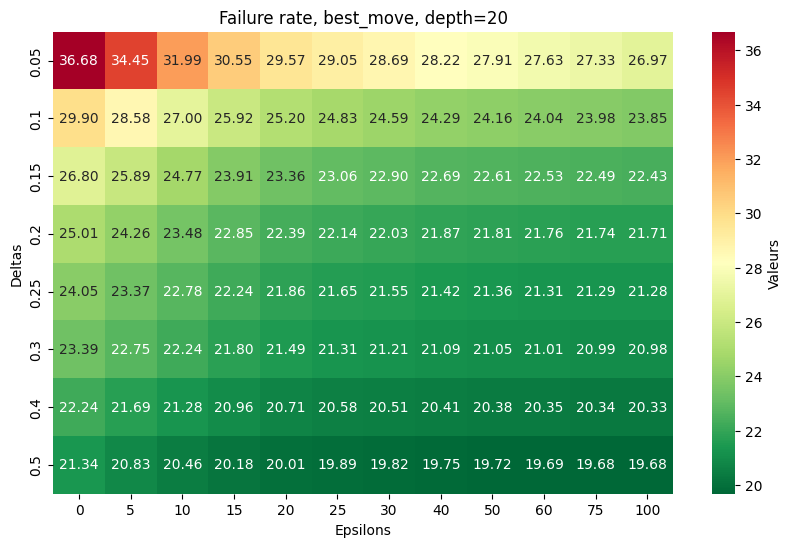

In [89]:
path = os.path.join('best_move_d=20','evaluations50000_best_move_d_20.pkl')
with open(path, 'rb') as file:
    evaluations50000_best_move_d_20 = pickle.load(file)

tests(evaluations50000_best_move_d_20,4,20)

#### depth = 20, splitting

In [90]:
print("Mates proportion : ", len(split_mate_cp(evaluations50000_best_move_d_20)[1])/(len(split_mate_cp(evaluations50000_best_move_d_20)[0])+len(split_mate_cp(evaluations50000_best_move_d_20)[1])))

Mates proportion :  0.5246750167924453


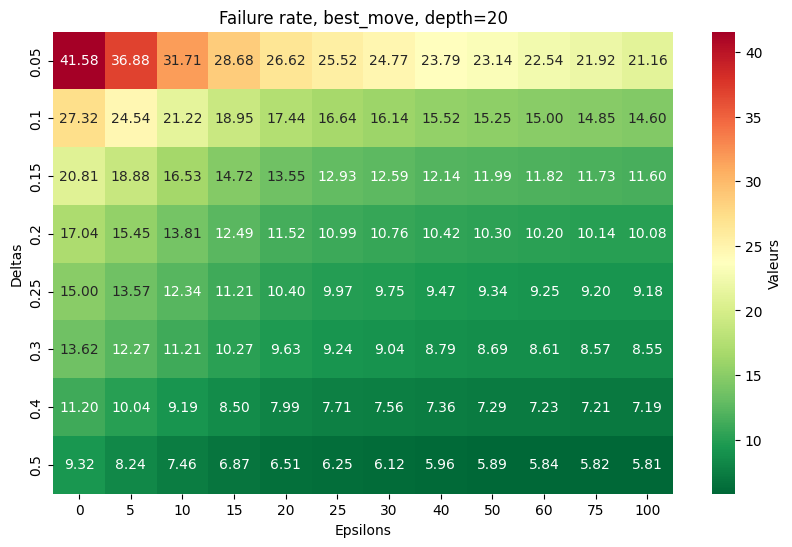

In [91]:
tests(split_mate_cp(evaluations50000_best_move_d_20)[0],4,20)

In [92]:
print('Mates failure rate : ',100-MR(split_mate_cp(evaluations50000_best_move_d_20)[1],4,1,1),'%')

Mates failure rate :  32.23887340914226 %


#### depth = 20, real positions

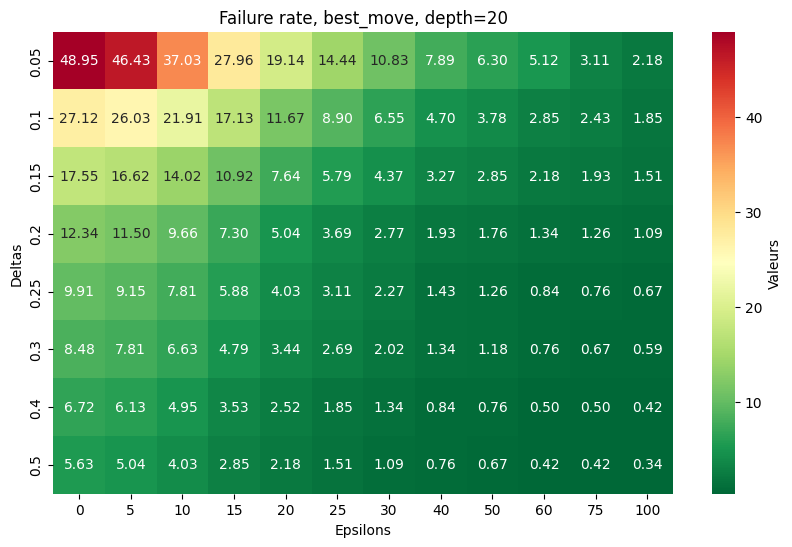

In [93]:
evaluations50000_best_move_d_20_real = real_positions(evaluations50000_best_move_d_20[22000:])
evaluations50000_best_move_d_20_real.reset_index(drop=True, inplace=True)
tests(evaluations50000_best_move_d_20_real,4,20)

### Analysis on biggest gaps

#### Additional function

Here is a function to plot evaluations by depth, until the MR is verified and the minimum depth (min_d) is reached. Will stop at max_d if can't verify MR before.

In [127]:
def plotevas(data1,data2,val,type):
    print('MR verified at depth = ', val)
    ind1 = 0
    ind2 = 0
    cp1 = []
    cp2 = []
    mate1 = []
    mate2 = []
    values1cp = []
    values1mate = []
    values2cp = []
    values2mate = []
    if type == 4:
        for data in data1:
            ind1+=1
            if data.get('Mate') == None:
                cp1.append(ind1)
                values1cp.append(data.get('Centipawn'))
            else:
                mate1.append(ind1)
                values1mate.append(data.get('Mate'))

        for data in data2:
            ind2+=1
            if data.get('Mate') == None:
                cp2.append(ind2)
                values2cp.append(data.get('Centipawn'))
            else:
                mate2.append(ind2)
                values2mate.append(data.get('Mate'))
    else:
        for data in data1:
            ind1+=1
            if data.get('type') == 'cp':
                cp1.append(ind1)
                values1cp.append(data.get('value'))
            else:
                values1mate.append(data.get('value'))
                mate1.append(ind1)
        for data in data2:
            ind2+=1
            if type == 0:
                if data.get('type') == 'cp':
                    cp2.append(ind2)
                    values2cp.append(data.get('value') * (-1))
                else:
                    mate2.append(ind2)
                    values2mate.append(data.get('value') * (-1))

            else:
                if data.get('type') == 'cp':
                    cp2.append(ind2)
                    values2cp.append(data.get('value'))
                else:
                    mate2.append(ind2)
                    values2mate.append(data.get('value'))


    plt.plot(cp1, values1cp, '-', color='#17d1d3')
    plt.plot(cp2, values2cp, '--',color='#405ee3')

    plt.grid(axis='y', color='#D3D3D3', linestyle='-', linewidth=0.5)


    plt.ylabel('Centipawn advantage', color='blue')
    plt.tick_params('y', colors='blue')



    plt.twinx()

    plt.plot(mate1, values1mate, '-', color='#f7766d')
    plt.plot(mate2, values2mate, '--', color='#df2c1f')
    
    plt.ylabel('Mate in', color='red')
    plt.tick_params('y', colors='red')
    
    plt.show()

We are using delta = 0.25 and epsilon = 25 for these tests.

#### Stockfish returning opposite evaluations

#### sim_mirror, sim_axis

No evidences of really large gaps.

REMINDER : with sim_mirror, since the mutation swap colors, the evaluation of the original position has to match with (-1)*the mutated evaluation.

In [95]:
p8mirror = 'r1b2rk1/p3n1pp/1pn1p3/q1ppPp2/3P4/P1PB1NQ1/2PB1PPP/R3K2R w'

show_pos([p8mirror],300)
print(evaluationdouble(p8mirror,sim_mirror(p8mirror),50000,20))
print(evaluationdouble(p8mirror,sim_axis(p8mirror),50000,20))


({'type': 'cp', 'value': -32}, {'type': 'cp', 'value': -63})
({'type': 'cp', 'value': -32}, {'type': 'cp', 'value': 40})


MR verified at depth =  [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 28, 29, 30]


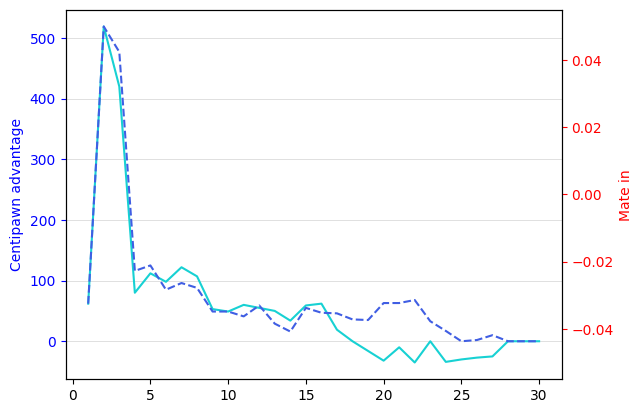

MR verified at depth =  [2, 3, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 17, 21, 23, 24, 25, 27, 30]


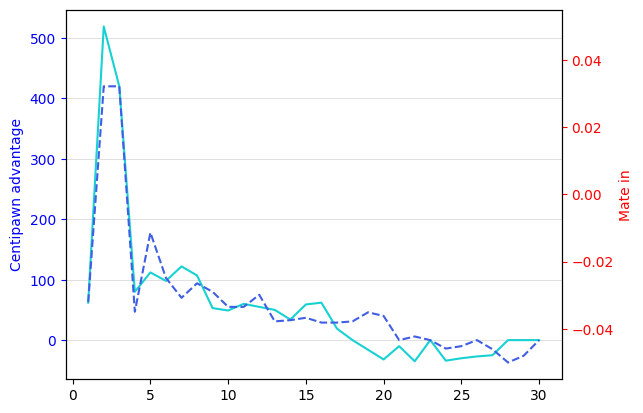

In [96]:
chemin = os.path.join('plotevas', 'p8mirror.pkl')
with open(chemin, 'rb') as fichier:
    plot8mirror = pickle.load(fichier)

plotevas(plot8mirror[0],plot8mirror[1],plot8mirror[2], 0)

chemin = os.path.join('plotevas', 'p8axis.pkl')
with open(chemin, 'rb') as fichier:
    plot8axis = pickle.load(fichier)

plotevas(plot8axis[0],plot8axis[1],plot8axis[2], 1)

#### best_move

In [97]:
p1best = 'r2q1rk1/4bppp/3pb3/2n1pP2/1p2P1PP/1P3Q2/1BP1N1B1/2KR3R w'

show_pos([p1best],300)
print(evaluation(p1best,50000,20)[1],evaluation(sim_axis(p1best),50000,20)[1])

[{'Move': 'f5e6', 'Centipawn': 74, 'Mate': None}] [{'Move': 'c5d6', 'Centipawn': -12, 'Mate': None}]


MR verified at depth =  [2, 5, 6, 7, 10, 11, 12, 14, 15, 17, 21, 23, 24, 25, 26, 28, 29, 30]


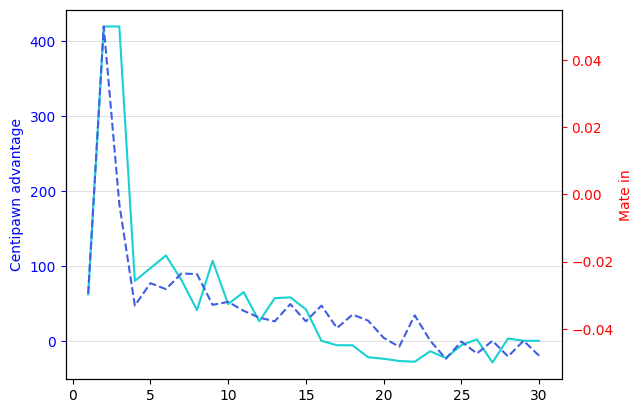

In [98]:
chemin = os.path.join('plotevas', 'p1best.pkl')
with open(chemin, 'rb') as fichier:
    plot1best = pickle.load(fichier)

plotevas(plot1best[0],plot1best[1],plot1best[2], 4)

#### Stockfish having troubles with draw positions at depth = 20

#### sim_mirror

In [99]:
p1mirror = '8/8/7k/8/4K3/4r3/2B4P/8 w'
p2mirror = '7b/8/kq6/8/8/1N2R3/K2P4/8 w'

show_pos([p1mirror,p2mirror],300)
print(evaluationdouble(p1mirror,sim_mirror(p1mirror),50000,20))
print(evaluationdouble(p2mirror,sim_mirror(p2mirror),50000,20))

({'type': 'cp', 'value': 0}, {'type': 'cp', 'value': -402})
({'type': 'cp', 'value': -478}, {'type': 'cp', 'value': 0})


It was in fact verified with a lower depth, but it is verified again with an higher depth. For the first one, it also gets verified at depth 23 with false values.

MR verified at depth =  [2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 25, 28, 29, 30]


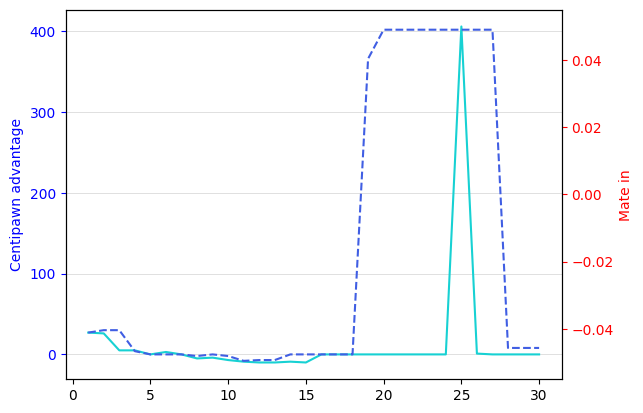

MR verified at depth =  [2, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 22, 23, 24, 25, 26, 27, 28, 29, 30]


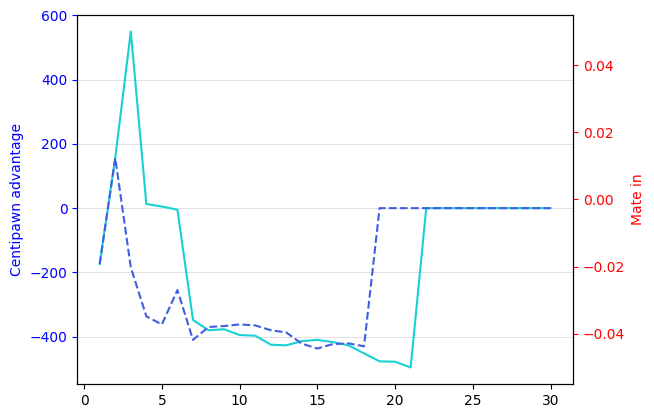

In [100]:
chemin = os.path.join('plotevas', 'p1mirror.pkl')
with open(chemin, 'rb') as fichier:
    plot1mirror = pickle.load(fichier)

plotevas(plot1mirror[0],plot1mirror[1],plot1mirror[2], 0)

chemin = os.path.join('plotevas', 'p2mirror.pkl')
with open(chemin, 'rb') as fichier:
    plot2mirror = pickle.load(fichier)


plotevas(plot2mirror[0],plot2mirror[1],plot2mirror[2], 0)

#### sim_axis, sim_diag

In [124]:
print(evaluationdouble(p1mirror,sim_axis(p1mirror),50000,20))
print(evaluationdouble(p2mirror,sim_axis(p2mirror),50000,20))

print(evaluationdouble(p1mirror,sim_diag(p1mirror),50000,20))
print(evaluationdouble(p2mirror,sim_diag(p2mirror),50000,20))

print(evaluation(p1mirror,50000,20)[1],evaluation(sim_axis(p1mirror),50000,20)[1])
print(evaluation(p2mirror,50000,20)[1],evaluation(sim_axis(p2mirror),50000,20)[1])

({'type': 'cp', 'value': 0}, {'type': 'cp', 'value': 0})
({'type': 'cp', 'value': -478}, {'type': 'cp', 'value': -477})
({'type': 'cp', 'value': 0}, {'type': 'cp', 'value': 0})
({'type': 'cp', 'value': -478}, {'type': 'cp', 'value': -698})
[{'Move': 'e4e3', 'Centipawn': 0, 'Mate': None}] [{'Move': 'd4d3', 'Centipawn': 0, 'Mate': None}]
[{'Move': 'a2b1', 'Centipawn': -501, 'Mate': None}] [{'Move': 'h2g1', 'Centipawn': -498, 'Mate': None}]


Stockfish doesn't fail on the two previous position in sim_axis. Couldn't find other examples.

#### Stockfish showing gaps in evaluation on non-draw positions at depth = 20

#### sim_mirror

In [102]:
p3mirror = '8/K7/3N4/2PR2r1/n2k4/3p3N/4Pn2/6B1 b'
p4mirror = '8/2p1k3/3p3p/2PP1pp1/1P1K1P2/6P1/8/8 w'
show_pos([p3mirror,p4mirror],300)

print(evaluationdouble(p3mirror,sim_mirror(p3mirror),50000,20))
print(evaluationdouble(p4mirror,sim_mirror(p4mirror),50000,20))


({'type': 'cp', 'value': -222}, {'type': 'cp', 'value': 2})
({'type': 'cp', 'value': -1}, {'type': 'cp', 'value': -277})


MR verified at depth =  [2, 3, 4, 8, 9, 10, 11, 13, 14, 15, 16, 22, 23, 24, 25, 26, 27, 28, 29, 30]


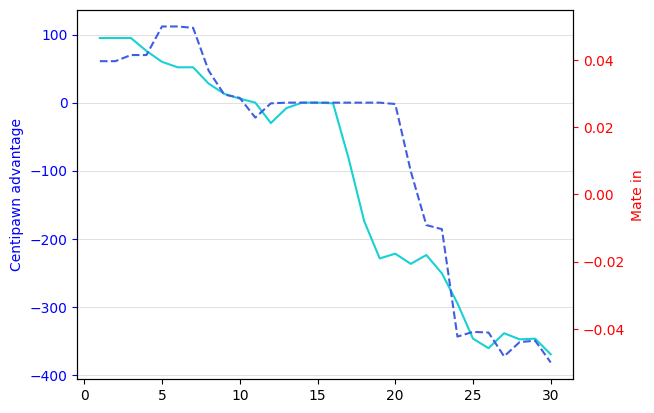

MR verified at depth =  [2, 3, 4, 8, 9, 10, 11, 13, 14, 15, 16, 22, 23, 24, 25, 26, 27, 28, 29, 30]


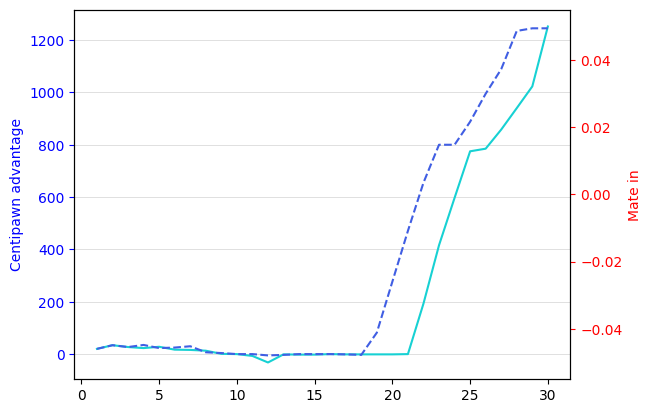

In [103]:
chemin = os.path.join('plotevas', 'p3mirror.pkl')
with open(chemin, 'rb') as fichier:
    plot3mirror = pickle.load(fichier)

plotevas(plot3mirror[0],plot3mirror[1],plot3mirror[2], 0)

chemin = os.path.join('plotevas', 'p4mirror.pkl')
with open(chemin, 'rb') as fichier:
    plot4mirror = pickle.load(fichier)

plotevas(plot4mirror[0],plot4mirror[1],plot3mirror[2], 0)

Stockfish shows a similar behaviour with the second position when using sim_axis.

#### sim_axis

In [104]:
p3axis = '1K6/3R2kr/8/8/8/BQ5r/2b1r3/5n2 b'
p2axis = 'rn1qr1k1/1p2bppp/p3p3/3pP3/P2P1B2/2RB1Q1P/1P3PP1/R5K1 w'
show_pos([p3axis,p2axis],300)

print(evaluationdouble(p3axis,sim_axis(p3axis),50000,20))
print(evaluationdouble(p2axis,sim_axis(p2axis),50000,20))

({'type': 'cp', 'value': 286}, {'type': 'cp', 'value': 48})
({'type': 'cp', 'value': 129}, {'type': 'cp', 'value': 344})


MR verified at depth =  [2, 4, 7, 9, 10, 11, 12, 13, 14, 15, 23, 28, 29, 30]


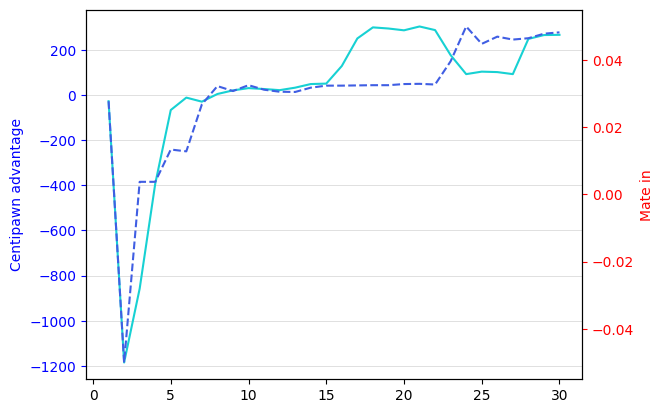

MR verified at depth =  [2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 22, 23, 24, 25, 26, 27, 28, 29, 30]


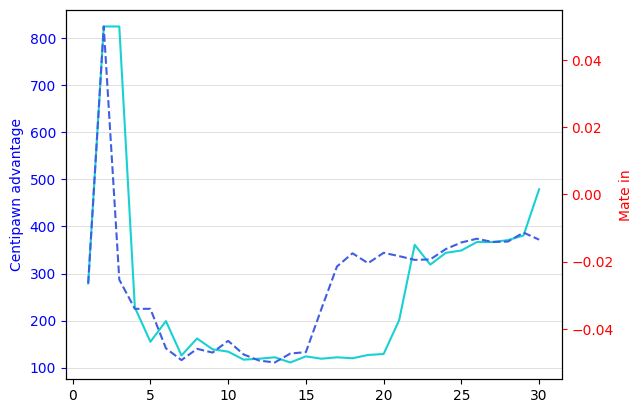

In [105]:
chemin = os.path.join('plotevas', 'p3axis.pkl')
with open(chemin, 'rb') as fichier:
    plot3axis = pickle.load(fichier)

plotevas(plot3axis[0],plot3axis[1],plot3axis[2], 1)

chemin = os.path.join('plotevas', 'p2axis.pkl')
with open(chemin, 'rb') as fichier:
    plot2axis = pickle.load(fichier)

plotevas(plot2axis[0],plot2axis[1],plot2axis[2], 1)

#### sim_diag

In [106]:
p3diag = 'N7/8/1n6/3B4/4r3/4k3/2K5/6r1 w '
p2diag = '8/8/8/n3N3/2Q1r3/5k2/1K6/8 b'
show_pos([p3diag,p2diag],300)

print(evaluationdouble(p3diag,sim_diag(p3diag),50000,20))
print(evaluationdouble(p2diag,sim_diag(p2diag),50000,20))

({'type': 'cp', 'value': -89}, {'type': 'cp', 'value': -246})
({'type': 'cp', 'value': 360}, {'type': 'cp', 'value': 145})


MR verified at depth =  [2, 9, 11, 12, 13, 14, 15, 16, 18, 37]


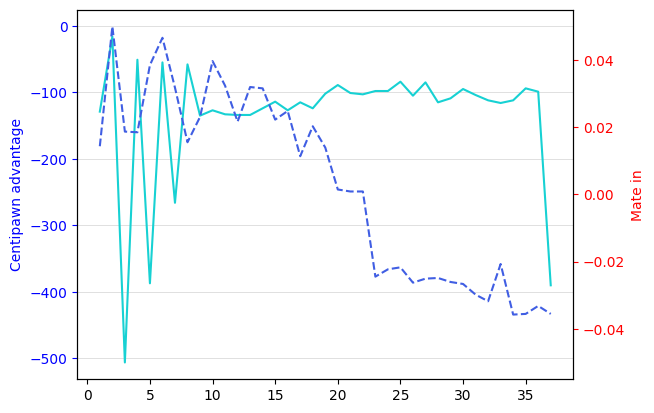

MR verified at depth =  [3, 8, 9, 10, 11, 12, 13, 14, 15, 16, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]


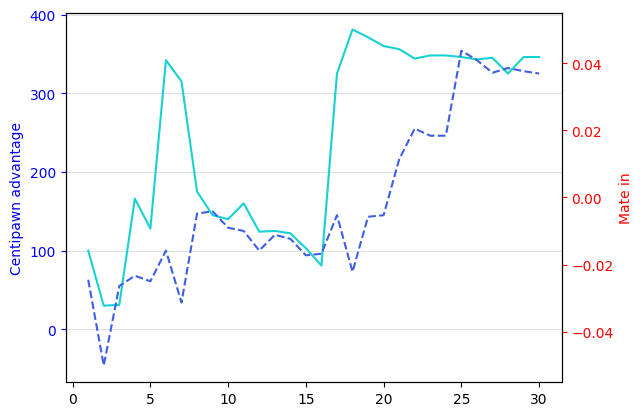

In [107]:
chemin = os.path.join('plotevas', 'p3diag.pkl')
with open(chemin, 'rb') as fichier:
    plot3diag = pickle.load(fichier)

plotevas(plot3diag[0],plot3diag[1],plot3diag[2], 2)

chemin = os.path.join('plotevas', 'p2diag.pkl')
with open(chemin, 'rb') as fichier:
    plot2diag = pickle.load(fichier)

plotevas(plot2diag[0],plot2diag[1],plot2diag[2], 2)

#### best_move

In [108]:
p2best = '8/1BK5/8/1pk5/8/8/5P2/8 b'
p3best = '4K3/1P6/4Rqk1/6B1/4N2N/2q3r1/b1np4/8 b'
show_pos([p2best,p3best],300)

print(evaluation(p2best,50000,20)[1],evaluation(sim_axis(p2best),50000,20)[1])
print(evaluation(p3best,50000,20)[1],evaluation(sim_axis(p3best),50000,20)[1])

[{'Move': 'b5b4', 'Centipawn': 0, 'Mate': None}] [{'Move': 'g5g4', 'Centipawn': 731, 'Mate': None}]
[{'Move': 'g6h5', 'Centipawn': -300, 'Mate': None}] [{'Move': 'b6a5', 'Centipawn': -43, 'Mate': None}]


MR verified at depth =  [2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 16, 17, 18, 19, 22, 23, 24, 25]


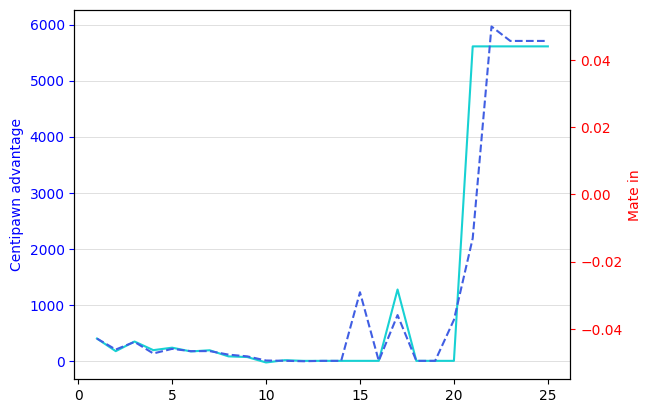

MR verified at depth =  [2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 21, 22, 23, 24, 25]


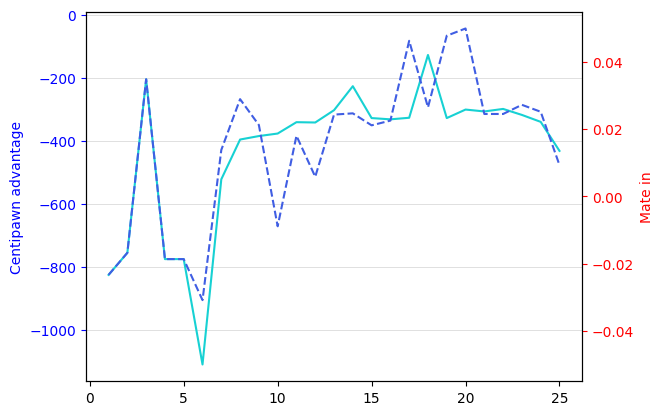

In [123]:
chemin = os.path.join('plotevas', 'p2best.pkl')
with open(chemin, 'rb') as fichier:
    plot2best = pickle.load(fichier)

plotevas(plot2best[0],plot2best[1],plot2best[2], 4)

chemin = os.path.join('plotevas', 'p3best.pkl')
with open(chemin, 'rb') as fichier:
    plot3best = pickle.load(fichier)

plotevas(plot3best[0],plot3best[1],plot3best[2], 4)

#### Stockfish fails to get the same mate value at depth = 20 on positions

#### sim_mirror

In [109]:
p5mirror = '3b4/6k1/8/8/4N3/8/q7/2K1Rn2 w'
show_pos([p5mirror],300)
print(evaluationdouble(p5mirror,sim_mirror(p5mirror),50000,20))

({'type': 'mate', 'value': -25}, {'type': 'mate', 'value': 32})


MR verified at depth =  [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 23, 24, 26, 27, 32]


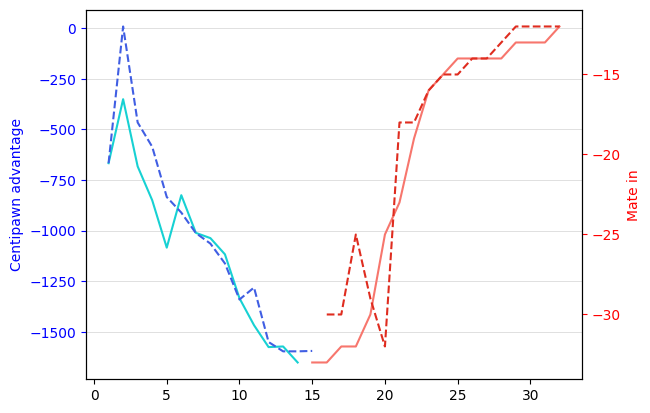

In [110]:
chemin = os.path.join('plotevas', 'p5mirror.pkl')
with open(chemin, 'rb') as fichier:
    plot5mirror = pickle.load(fichier)

plotevas(plot5mirror[0],plot5mirror[1],plot5mirror[2], 0)

#### sim_axis

In [111]:
p4axis = '3N4/8/B3k3/1RK2B2/8/8/4P2r/6B1 b'
show_pos([p4axis],300)
print(evaluationdouble(p4axis,sim_axis(p4axis),50000,20))

({'type': 'mate', 'value': 11}, {'type': 'mate', 'value': 17})


MR verified at depth =  [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 24, 25, 26, 27, 28, 29, 30]


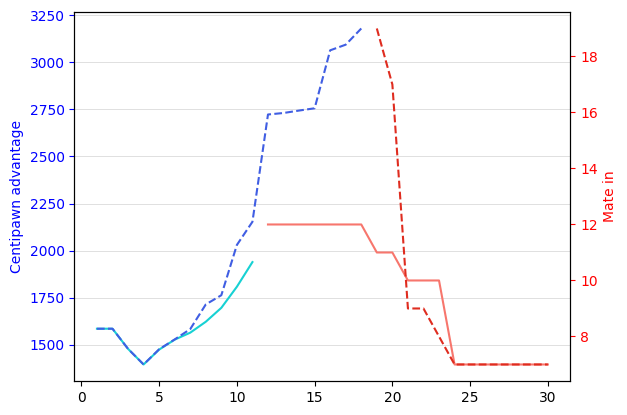

In [112]:
chemin = os.path.join('plotevas', 'p4axis.pkl')
with open(chemin, 'rb') as fichier:
    plot4axis = pickle.load(fichier)

plotevas(plot4axis[0],plot4axis[1],plot4axis[2], 1)

#### sim_diag

In [113]:
p4diag = '8/1nK5/6k1/8/6n1/8/8/4B1Qn b'
show_pos([p4diag],300)
print(evaluationdouble(p4diag,sim_diag(p4diag),50000,20))

({'type': 'cp', 'value': 15265}, {'type': 'mate', 'value': 40})


MR verified at depth =  [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 30]


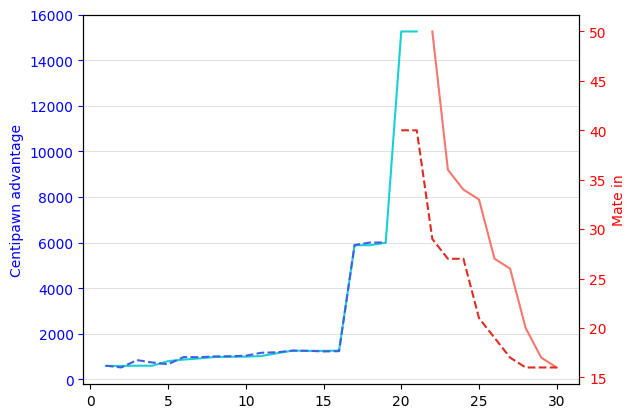

In [114]:
chemin = os.path.join('plotevas', 'p4diag.pkl')
with open(chemin, 'rb') as fichier:
    plot4diag = pickle.load(fichier)

plotevas(plot4diag[0],plot4diag[1],plot4diag[2], 2)

#### best_move

In [125]:
p4best = '1n6/8/8/8/1K6/5pP1/3P1n2/2k5 w'
show_pos([p4best],300)

print(evaluation(p4best,50000,20)[1],evaluation(sim_axis(p4best),50000,20)[1])

[{'Move': 'd2d4', 'Centipawn': None, 'Mate': -56}] [{'Move': 'e2e4', 'Centipawn': None, 'Mate': -52}]


MR verified at depth =  [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 18, 31]


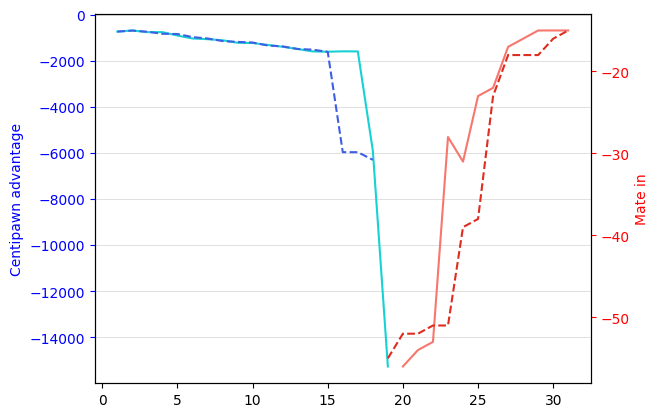

In [128]:
chemin = os.path.join('plotevas', 'p4best.pkl')
with open(chemin, 'rb') as fichier:
    plot4best = pickle.load(fichier)

plotevas(plot4best[0],plot4best[1],plot4best[2], 4)

#### Stockfish behaviour with near-mate positions

#### sim_mirror

In [115]:
p6mirror = '8/1BK5/8/1pk5/8/8/5P2/8 b'
p7mirror = '3K4/8/7N/6n1/8/3k4/3p4/8 w'
show_pos([p6mirror,p7mirror],300)
print(evaluationdouble(p6mirror,sim_mirror(p6mirror),50000,20))
print(evaluationdouble(p7mirror,sim_mirror(p7mirror),50000,20))

({'type': 'cp', 'value': 0}, {'type': 'cp', 'value': -1293})
({'type': 'cp', 'value': -15265}, {'type': 'cp', 'value': 5964})


MR verified at depth =  [2, 3, 4, 5, 6, 7, 8, 9, 21, 23, 24, 26, 35]


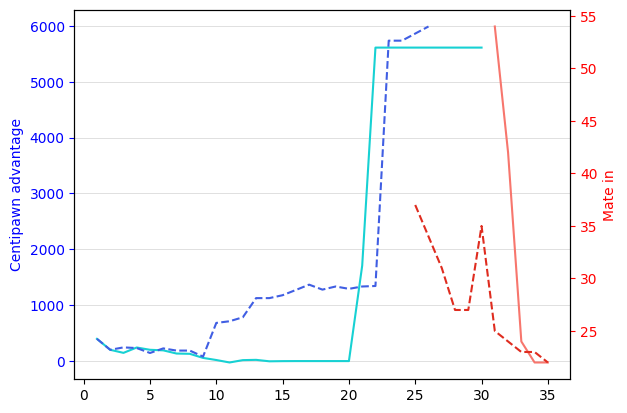

MR verified at depth =  [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 24, 26, 27, 29, 49]


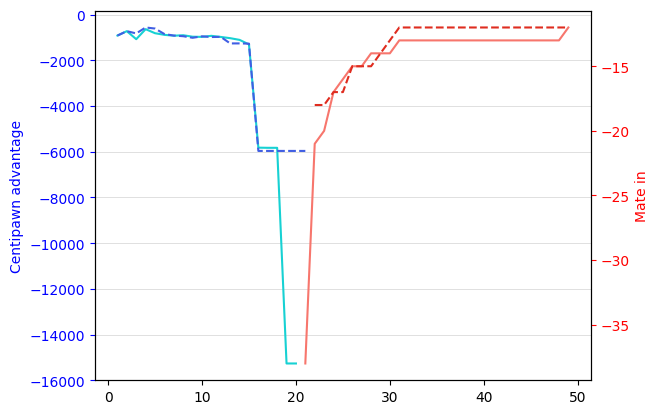

In [116]:
chemin = os.path.join('plotevas', 'p6mirror.pkl')
with open(chemin, 'rb') as fichier:
    plot6mirror = pickle.load(fichier)

plotevas(plot6mirror[0],plot6mirror[1],plot6mirror[2], 0)

chemin = os.path.join('plotevas', 'p7mirror.pkl')
with open(chemin, 'rb') as fichier:
    plot7mirror = pickle.load(fichier)

plotevas(plot7mirror[0],plot7mirror[1],plot7mirror[2], 0)

#### sim_axis

In [117]:
p5axis = '3RR3/6k1/K7/8/8/7r/8/8 b'
show_pos([p5axis],300)
print(evaluationdouble(p5axis,sim_axis(p5axis),50000,20))

({'type': 'cp', 'value': 740}, {'type': 'cp', 'value': 5480})


MR verified at depth =  [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 23, 24, 27, 28, 31, 40]


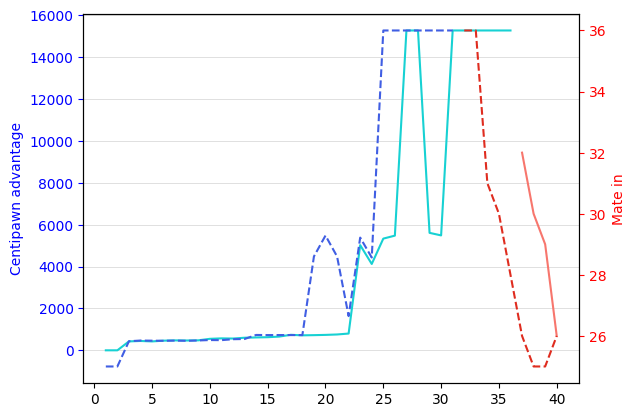

In [118]:
chemin = os.path.join('plotevas', 'p5axis.pkl')
with open(chemin, 'rb') as fichier:
    plot5axis = pickle.load(fichier)

plotevas(plot5axis[0],plot5axis[1],plot5axis[2], 1)

It eventually converges at a certain point.

#### sim_diag

In [119]:
p5diag = '3r4/8/8/R2K4/8/8/2N3r1/5k2 w'
show_pos([p5diag],300)
print(evaluationdouble(p5diag,sim_diag(p5diag),50000,20))

({'type': 'cp', 'value': -727}, {'type': 'cp', 'value': -5502})


MR verified at depth =  [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 22, 23, 24, 31, 53]


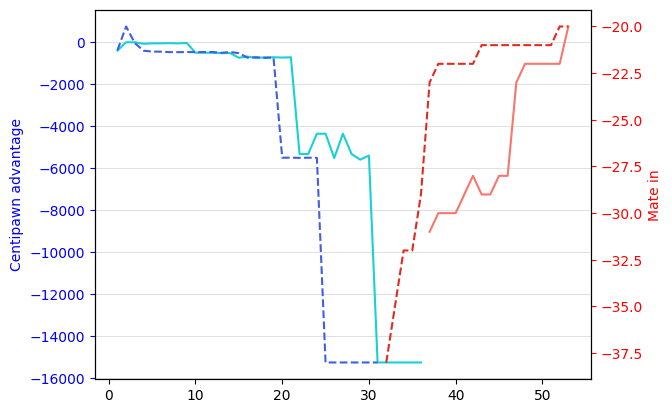

In [120]:
chemin = os.path.join('plotevas', 'p5diag.pkl')
with open(chemin, 'rb') as fichier:
    plot5diag = pickle.load(fichier)

plotevas(plot5diag[0],plot5diag[1],plot5diag[2], 2)

#### best_move

In [129]:
p5best = 'q1B1R3/2k4R/8/pP6/2B5/r4q2/1R1B4/1K2R2q b'
show_pos([p5best],300)
print(evaluation(p5best,50000,20)[1],evaluation(sim_axis(p5best),50000,20)[1])

[{'Move': 'h1h7', 'Centipawn': -7925, 'Mate': None}] [{'Move': 'a1a7', 'Centipawn': -3229, 'Mate': None}]
